<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
# !pip install -U ydata_profiling coverage==7.6.1 numba matplotlib

In [2]:
import pandas as pd
import numpy as np
# import matplotlib
# matplotlib.use('qtagg')
import matplotlib.pyplot as plt
import random
import itertools
import seaborn as sns
from ydata_profiling import ProfileReport
from IPython.display import display, Markdown, HTML

import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

random.seed(42)
np.random.seed(42)
plt.close('all')

### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

`Your answer here` Сиды фиксируем для воспроизводимости результатов

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [3]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


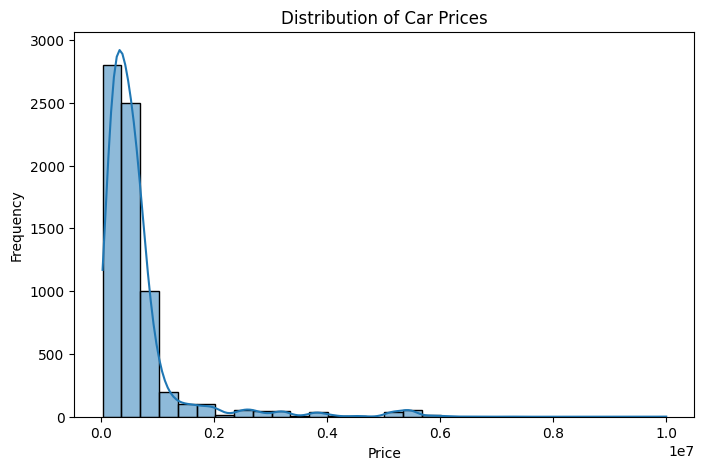

In [4]:
# matplotlib странно себя вёл. На всякий случай поставлю сюда пример использования, 
# чтобы можно было сразу проверять, работает ли бэкенд рендеринга.

# histogram selling_price
# (courtecy to copilot autocomplete)
plt.figure(figsize=(8, 5))
sns.histplot(df_train['selling_price'], bins=30, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

In [5]:
def check_cols_for_nulls(df, mode="presense"):
    if mode == "presense":
        return df.isnull().sum() > 0
    elif mode == "count":
        return df.isnull().sum()
    elif mode == "percent":
        return df.isnull().mean()
    else:
        raise ValueError("mode must be 'presense', 'count' or 'percent'")

display(Markdown("**Пропуски в данных (train сплит):**"))
display(Markdown("Наличие (количество и долю можно вывести, заменив \"presense\" на \"count\" или \"percent\"):"))
display(check_cols_for_nulls(df_train, "presense"))

display(Markdown("**Пропуски в данных (test сплит):**"))
display(Markdown("Наличие (количество и долю можно вывести, заменив \"presense\" на \"count\" или \"percent\"):"))
display(check_cols_for_nulls(df_test, "presense"))


**Пропуски в данных (train сплит):**

Наличие (количество и долю можно вывести, заменив "presense" на "count" или "percent"):

name             False
year             False
selling_price    False
km_driven        False
fuel             False
seller_type      False
transmission     False
owner            False
mileage           True
engine            True
max_power         True
torque            True
seats             True
dtype: bool

**Пропуски в данных (test сплит):**

Наличие (количество и долю можно вывести, заменив "presense" на "count" или "percent"):

name             False
year             False
selling_price    False
km_driven        False
fuel             False
seller_type      False
transmission     False
owner            False
mileage           True
engine            True
max_power         True
torque            True
seats             True
dtype: bool

In [6]:
display(Markdown(
    f"""**Дубликаты в данных (train сплит):** 
    {df_train.duplicated().sum()}
    , что составляет 
    {df_train.duplicated().mean()*100:.1f}%
    из {len(df_train)} строк"""
))

display(Markdown(
    f"""**Дубликаты в данных (test сплит):** 
    {df_test.duplicated().sum()}
    , что составляет 
    {df_test.duplicated().mean()*100:.1f}%
    из {len(df_test)} строк"""
))

**Дубликаты в данных (train сплит):** 
    985
    , что составляет 
    14.1%
    из 6999 строк

**Дубликаты в данных (test сплит):** 
    62
    , что составляет 
    6.2%
    из 1000 строк

In [7]:
profile = ProfileReport(df_train, title="Profiling Report (train split)")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 292.05it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Выводы? В целом всё как и бывает.
# есть очевидные интерпретируемые корреляции (например, свежесть машины и цена, или пробег и цена, или пробег и свежесть)
# mileage, engine, max_power, torque -- было бы хорошо распарсить в числа
# По дубликатам -- 30 объявлений одной и той же машины? :D

Достаточно много пропущенных, количество дубликатов не так критично.

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [ ] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [9]:
display(Markdown("**Статистики (как категориальные так и числовые) по данным (train сплит):**"))
display(df_train.describe(include='all'))

display(Markdown("**Статистики (как категориальные так и числовые) по данным (test сплит):**"))
display(df_test.describe(include='all'))

# relative difference of every numerical statistic from .describe() between train and test splits
# (courtesy to copilot autocomplete (✿◡‿◡) )
use_cols = df_train.select_dtypes(include=[np.number]).columns
train_desc = df_train[use_cols].describe().T
test_desc = df_test[use_cols].describe().T
rel_diff = (train_desc - test_desc).abs() / (train_desc.abs() + test_desc.abs()) / 2 * 100
rel_diff = rel_diff[['mean', 'std', '25%', '50%', '75%']]
display(Markdown("*Относительные различия числовых статистик между train и test сплитами __(в процентах)__:*"))
display(rel_diff)

**Статистики (как категориальные так и числовые) по данным (train сплит):**

name         year  selling_price     km_driven  \
count                     6999  6999.000000   6.999000e+03  6.999000e+03   
unique                    1924          NaN            NaN           NaN   
top     Maruti Swift Dzire VDI          NaN            NaN           NaN   
freq                       116          NaN            NaN           NaN   
mean                       NaN  2013.818403   6.395152e+05  6.958462e+04   
std                        NaN     4.053095   8.089419e+05  5.772400e+04   
min                        NaN  1983.000000   2.999900e+04  1.000000e+00   
25%                        NaN  2011.000000   2.549990e+05  3.500000e+04   
50%                        NaN  2015.000000   4.500000e+05  6.000000e+04   
75%                        NaN  2017.000000   6.750000e+05  9.700000e+04   
max                        NaN  2020.000000   1.000000e+07  2.360457e+06   

          fuel seller_type transmission        owner    mileage   engine  \
count     6999        6999         6999         6999       6797     6797   
unique       4           3            2            5        386      120   
top     Diesel  Individual       Manual  First Owner  18.9 kmpl  1248 CC   
freq      3793        5826         6095         4587        197      885   
mean       NaN         NaN          NaN          NaN        NaN      NaN   
std        NaN         NaN          NaN          NaN        NaN      NaN   
min        NaN         NaN          NaN          NaN        NaN      NaN   
25%        NaN         NaN          NaN          NaN        NaN      NaN   
50%        NaN         NaN          NaN          NaN        NaN      NaN   
75%        NaN         NaN          NaN          NaN        NaN      NaN   
max        NaN         NaN          NaN          NaN        NaN      NaN   

       max_power          torque        seats  
count       6803            6796  6797.000000  
unique       316             419          NaN  
top       74 bhp  190Nm@ 2000rpm          NaN  
freq         330             468          NaN  
mean         NaN             NaN     5.419008  
std          NaN             NaN     0.965767  
min          NaN             NaN     2.000000  
25%          NaN             NaN     5.000000  
50%          NaN             NaN     5.000000  
75%          NaN             NaN     5.000000  
max          NaN             NaN    14.000000

**Статистики (как категориальные так и числовые) по данным (test сплит):**

name         year  selling_price      km_driven  \
count                  1000  1000.000000   1.000000e+03    1000.000000   
unique                  621          NaN            NaN            NaN   
top     Maruti Alto 800 LXI          NaN            NaN            NaN   
freq                     15          NaN            NaN            NaN   
mean                    NaN  2013.681000   6.179010e+05   71393.341000   
std                     NaN     4.012149   7.585539e+05   48486.218662   
min                     NaN  1995.000000   3.100000e+04    1303.000000   
25%                     NaN  2011.000000   2.500000e+05   37000.000000   
50%                     NaN  2014.000000   4.349990e+05   61500.000000   
75%                     NaN  2017.000000   6.700000e+05  100000.000000   
max                     NaN  2020.000000   6.000000e+06  375000.000000   

          fuel seller_type transmission        owner    mileage   engine  \
count     1000        1000         1000         1000        981      981   
unique       4           3            2            5        237       88   
top     Diesel  Individual       Manual  First Owner  18.6 kmpl  1248 CC   
freq       534         837          877          623         23      116   
mean       NaN         NaN          NaN          NaN        NaN      NaN   
std        NaN         NaN          NaN          NaN        NaN      NaN   
min        NaN         NaN          NaN          NaN        NaN      NaN   
25%        NaN         NaN          NaN          NaN        NaN      NaN   
50%        NaN         NaN          NaN          NaN        NaN      NaN   
75%        NaN         NaN          NaN          NaN        NaN      NaN   
max        NaN         NaN          NaN          NaN        NaN      NaN   

       max_power          torque       seats  
count        981             981  981.000000  
unique       182             226         NaN  
top       74 bhp  200Nm@ 1750rpm         NaN  
freq          43              57         NaN  
mean         NaN             NaN    5.410805  
std          NaN             NaN    0.919985  
min          NaN             NaN    4.000000  
25%          NaN             NaN    5.000000  
50%          NaN             NaN    5.000000  
75%          NaN             NaN    5.000000  
max          NaN             NaN    9.000000

*Относительные различия числовых статистик между train и test сплитами __(в процентах)__:*

mean       std       25%       50%       75%
year           0.001706  0.253844  0.000000  0.012410  0.000000
selling_price  0.859467  1.607279  0.494951  0.847515  0.185874
km_driven      0.641492  4.348820  1.388889  0.617284  0.761421
seats          0.037873  1.213874  0.000000  0.000000  0.000000

In [10]:
# Вывод: разница в количественных статичтиках (а именно, avg/std/квартили-без-minmax) заметна (порядка 1%), но всё ещё объяснима рандомом.

# P.S.: хотя я бы всё равно потооом обучил классификатор на детекцию train-или-test на случай Out Of Distribution training

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [ ] Отобразите такие объекты (0.01 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [ ] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

In [11]:
df_train_without_target = df_train.drop(columns=['selling_price'])
display(Markdown("**Количество дупликатов в трейне, не считая цены:**"))
display(Markdown(f"""{df_train_without_target.duplicated().sum()}, что составляет {df_train_without_target.duplicated().mean() * 100:.2f}% от всех записей."""))

display(Markdown("**Примеры:**"))
display(df_train_without_target[df_train_without_target.duplicated()].head(5))

**Количество дупликатов в трейне, не считая цены:**

1159, что составляет 16.56% от всех записей.

**Примеры:**

name  year  km_driven    fuel  \
254                  Hyundai Grand i10 Sportz  2017      35000  Petrol   
258                          Maruti Swift VXI  2012      50000  Petrol   
268                    Maruti Swift Dzire VXI  2014      70000  Petrol   
324  Jaguar XE 2016-2019 2.0L Diesel Prestige  2017       9000  Diesel   
325                             Lexus ES 300h  2019      20000  Petrol   

    seller_type transmission         owner     mileage   engine   max_power  \
254  Individual       Manual   First Owner   18.9 kmpl  1197 CC      82 bhp   
258  Individual       Manual  Second Owner   18.6 kmpl  1197 CC    85.8 bhp   
268  Individual       Manual  Second Owner   19.1 kmpl  1197 CC    85.8 bhp   
324      Dealer    Automatic   First Owner   13.6 kmpl  1999 CC     177 bhp   
325      Dealer    Automatic   First Owner  22.37 kmpl  2487 CC  214.56 bhp   

                  torque  seats  
254       114Nm@ 4000rpm    5.0  
258       114Nm@ 4000rpm    5.0  
268       114Nm@ 4000rpm    5.0  
324  430Nm@ 1750-2500rpm    5.0  
325  202Nm@ 3600-5200rpm    5.0

In [12]:
df_train = df_train.drop_duplicates(subset=df_train_without_target.columns, keep='first')

In [13]:
assert df_train.shape == (5840, 13)

In [14]:
# rebuilding the index
# (courtesy to copilot autocomplete []~(￣▽￣)~* )
df_train = df_train.reset_index(drop=True)

In [15]:
# Главный вопрос:
# **А что вообще считать "скрытым дублем" ???**

# Могу предположить, что от меня ожидают рассказать про всякие случаи вроде:
# Либо это строки где число очень близко, но не равно (например, пробег 35000.0 и 35000.000000000004)
# Либо это уже in the realm of text/string штук которые мы пока что совершенно conveniently опускали
# Ну или если все признаки совпадают но какого-то просто нет (пробег 35к и None, а остальное совпадает)

# Иначе это наверное про что-то очень настолько очевидное что мой мозг не позволяет это написать :D

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [16]:
print(df_train['torque'].unique()[:30]) # Единицы измерения врооооооде бы выглядят консистентно -- нет "Krpm", например

['190Nm@ 2000rpm' '250Nm@ 1500-2500rpm' '22.4 kgm at 1750-2750rpm'
 '11.5@ 4,500(kgm@ rpm)' '113.75nm@ 4000rpm' '7.8@ 4,500(kgm@ rpm)'
 '59Nm@ 2500rpm' '170Nm@ 1800-2400rpm' '160Nm@ 2000rpm' '248Nm@ 2250rpm'
 '78Nm@ 4500rpm' nan '84Nm@ 3500rpm' '115Nm@ 3500-3600rpm' '62Nm@ 3000rpm'
 '219.7Nm@ 1500-2750rpm' '200Nm@ 1750rpm' '115Nm@ 4000rpm' '69Nm@ 3500rpm'
 '172.5Nm@ 1750rpm' '6.1kgm@ 3000rpm' '60Nm@ 3500rpm' '90Nm@ 3500rpm'
 '151Nm@ 4850rpm' '104Nm@ 4000rpm' '320Nm@ 1700-2700rpm'
 '250Nm@ 1750-2500rpm' '145Nm@ 4600rpm' '146Nm@ 4800rpm'
 '343Nm@ 1400-3400rpm']


In [17]:
# На всякий случай проверю а точно ли все единицы измерения хорошие
templates = set()

def fill_numbers_with_symbol(str_value, symbol='•'):
    if pd.isnull(str_value):
        return None
    if not isinstance(str_value, str):
        raise ValueError(f"Expected string value in 'torque' column, got {type(str_value)}: {str_value}")

    # replace all numbers with a special symbol •
    # example: "200Nm@ 1750rpm" -> "•Nm@ •rpm"
    # ( courtesy to copilot autocomplete (✿◡‿◡) )
    template = ''.join([symbol if ch.isdigit() or ch == '.' else ch for ch in str_value])
    template = ''.join([ch for i, ch in enumerate(template) if not (ch == symbol and i > 0 and template[i-1] == symbol)])
    return template

for value in df_train['torque'].unique():
    template = fill_numbers_with_symbol(value)
    if template is not None:
        templates.add(template)

print(len(templates), "unique templates found in 'torque' column:")
display(templates)

37 unique templates found in 'torque' column:


{'• / •',
 '• KGM at • RPM',
 '• KGM at •-• RPM',
 '• Nm /• rpm',
 '• Nm at •  rpm ',
 '• Nm at • rpm',
 '• Nm at • rpm ',
 '• Nm at •,•-•,• rpm',
 '• Nm at •-• rpm',
 '• Nm at •-•rpm',
 '• Nm at •rpm',
 '• kgm at • rpm',
 '• kgm at •,• rpm',
 '• kgm at •-•rpm',
 '•@ •(kgm@ rpm)',
 '•@ •,•(kgm@ rpm)',
 '•@ •,•+/-•(NM@ rpm)',
 '•@ •,•-•,•(kgm@ rpm)',
 '•@ •-•',
 '•@ •-•(kgm@ rpm)',
 '•@ •-•rpm',
 '•NM@ •-•rpm',
 '•NM@ •rpm',
 '•Nm',
 '•Nm at • rpm',
 '•Nm at •-• rpm',
 '•Nm(•kgm)@ •rpm',
 '•Nm@ •',
 '•Nm@ •+/-•rpm',
 '•Nm@ •,•rpm',
 '•Nm@ •-•',
 '•Nm@ •-•rpm',
 '•Nm@ •rpm',
 '•Nm@ •~•rpm',
 '•kgm@ •rpm',
 '•nm@ •-•rpm',
 '•nm@ •rpm'}

In [18]:
# Упс. Очень messy situation. 
# Где-то только один-два числа, где-то три;
# Там где три -- третье число может быть либо верхней границей диапазона, либо "+/-" отклонением.

# А есть ли больше трёх?
for template in templates:
    if template.count('•') > 3:
        print("Template with more than 3 numbers found:", template) # все три таких варианта можно свести к "хорошим" с помощью конвертации запятой в точку.

print("=" * 30)

# А можно ли безопасно конвертировать все запятые в точки?
for template in templates:
    if ',' in template and template.count('•') <= 3:
        print("Template with a comma:", template) # выглядит что можно, потому что запятая есть только в тех шаблонах, где это просто числа с запятой вместо точки.

        # upd: несколькими ячейками ниже выяснилось, что запятая может быть не разделителем десятичной дроби, а разделителем тысяч...
        # Например "11.5@ 4,500(kgm@ rpm)"
        # Бгг. Буду просто умножать rpm на 1000 если число меньше 100.


print("=" * 30)

# Точно ли все "+/-" шаблоны чистые?
for template in templates:
    if '+/-' in template:
        print("Template with '+/-':", template) # Вау их всего лишь два.


Template with more than 3 numbers found: •@ •,•+/-•(NM@ rpm)
Template with more than 3 numbers found: • Nm at •,•-•,• rpm
Template with more than 3 numbers found: •@ •,•-•,•(kgm@ rpm)
Template with a comma: •@ •,•(kgm@ rpm)
Template with a comma: • kgm at •,• rpm
Template with a comma: •Nm@ •,•rpm
Template with '+/-': •Nm@ •+/-•rpm
Template with '+/-': •@ •,•+/-•(NM@ rpm)


In [19]:
# Единицы измерения то Nm, то kgm. 
# 1 Nm = 0.10197 kgm
# 1 kgm = 9.80665 Nm

# Если не указано, будем потом угадывать по дистанции до медианы по Nm и kgm отдельно.

In [20]:
def extract_unsigned_numbers_from_string(s):
    # example: "200.25Nm@ 1750+/-51.4rpm" -> [200.25, 1750.0, 51.4]
    numbers = []
    current_number = ''
    for ch in s:
        if ch.isdigit() or ch == '.':
            current_number += ch
        else:
            if current_number:
                try:
                    numbers.append(float(current_number))
                except ValueError:
                    pass
                current_number = ''
    if current_number:
        try:
            numbers.append(float(current_number))
        except ValueError:
            pass
    return numbers

def convert_str_torque_to_numbers(torque_str, nm_avg=None, kgm_avg=None):
    
    if torque_str is None or pd.isnull(torque_str):
        return None, None, None, None
    
    had_comma = ',' in torque_str

    torque_str = torque_str.replace(',', '.')
    template = fill_numbers_with_symbol(torque_str)
    
    torque_value_nm = None
    torque_value_kgm = None
    rpm_min = None
    rpm_max = None
    if '+/-' in template:
        # Два варианта:
        # •Nm@ •+/-•rpm
        # •@ •+/-•(NM@ rpm)
        torque_value, rpm_base, rpm_plusminus = extract_unsigned_numbers_from_string(torque_str)
        rpm_min = rpm_base - rpm_plusminus
        rpm_max = rpm_base + rpm_plusminus
    elif template.count('•') == 3:
        # Если три значения, но при этом 
        # точки мы уже сконвертировали
        # и уже обработали +/-, 
        # то остаются только "• @ •-•" варианты с range of rpm
        torque_value, rpm_min, rpm_max = extract_unsigned_numbers_from_string(torque_str)
    elif template.count('•') == 2:
        torque_value, rpm_base = extract_unsigned_numbers_from_string(torque_str)
        rpm_min = rpm_base
        rpm_max = rpm_base
    elif template.count('•') == 1:
        torque_value = extract_unsigned_numbers_from_string(torque_str)[0]
        rpm_min = None
        rpm_max = None
    else:
        raise ValueError(f"Cannot extract numbers from torque string: {torque_str}")
    
    if had_comma:
        if rpm_min is not None and rpm_min < 100:
            rpm_min *= 1000
        if rpm_max is not None and rpm_max < 100:
            rpm_max *= 1000

    if 'nm' in torque_str.lower():
        torque_value_nm = torque_value
        torque_value_kgm = torque_value * 0.10197
    elif 'kgm' in torque_str.lower():
        torque_value_nm = torque_value * 9.80665
        torque_value_kgm = torque_value
    else:
        if nm_avg is not None and kgm_avg is not None: # (courtesy to copilot autocomplete (✿◡‿◡) )
            # в идеале бы конечно ещё дистанцию корректировать по std, 
            # но на практике наверное уже перебор, 
            # потому что относительные дистанции уже в некотором смысле учитывают 
            # *порядок* дистанций по сравнению с абсолютными разницами
            dist_to_nm = max(torque_value / nm_avg, nm_avg / torque_value) 
            dist_to_kgm = max(torque_value / kgm_avg, kgm_avg / torque_value)
            if dist_to_nm < dist_to_kgm:
                torque_value_nm = torque_value
                torque_value_kgm = torque_value * 0.10197
            else:
                torque_value_nm = torque_value * 9.80665
                torque_value_kgm = torque_value
        else:
            return None, None, None, None
            # raise ValueError("Cannot determine units for torque value without averages.")

    return torque_value_nm, torque_value_kgm, rpm_min, rpm_max

In [21]:
# Сначала всё прогоним просто так чтобы заполнить nm и kgm списки
all_values_nm = []
all_values_kgm = []

for value in df_train['torque']:
    if value is None or pd.isnull(value):
        continue

    torque_value_nm, torque_value_kgm, rpm_min, rpm_max = convert_str_torque_to_numbers(value)

    if torque_value_nm is None or torque_value_kgm is None:
        print("Could not convert torque value:", value)
        continue

    all_values_nm.append(torque_value_nm)
    all_values_kgm.append(torque_value_kgm)

print("=" * 30)
print(f"Average torque in Nm is {np.nanmean(all_values_nm):.2f} Nm among {len([v for v in all_values_nm if v is not None])} values")
print(f"Average torque in kgm is {np.nanmean(all_values_kgm):.2f} kgm among {len([v for v in all_values_kgm if v is not None])} values")
print("=" * 30)
print(f"Median torque in Nm is {np.nanmedian(all_values_nm):.2f} Nm among {len([v for v in all_values_nm if v is not None])} values")
print(f"Median torque in kgm is {np.nanmedian(all_values_kgm):.2f} kgm among {len([v for v in all_values_kgm if v is not None])} values")

Could not convert torque value: 250@ 1250-5000rpm
Could not convert torque value: 510@ 1600-2400
Could not convert torque value: 210 / 1900
Could not convert torque value: 210 / 1900
Could not convert torque value: 210 / 1900
Could not convert torque value: 210 / 1900
Could not convert torque value: 210 / 1900
Could not convert torque value: 210 / 1900
Could not convert torque value: 210 / 1900
Average torque in Nm is 175.75 Nm among 5644 values
Average torque in kgm is 17.92 kgm among 5644 values
Median torque in Nm is 160.00 Nm among 5644 values
Median torque in kgm is 16.32 kgm among 5644 values


In [22]:
# Теперь уже можно нормально конвертировать
nm_avg = np.nanmean(all_values_nm)
kgm_avg = np.nanmean(all_values_kgm)

def convert_torque_row(row):
    torque_str = row['torque']
    if torque_str is None or pd.isnull(torque_str):
        return pd.Series({
            'torque_nm': None,
            # 'torque_kgm': None,
            # 'torque_rpm_min': None,
            'torque_rpm_max': None
        })
    
    torque_value_nm, torque_value_kgm, rpm_min, rpm_max = convert_str_torque_to_numbers(torque_str, nm_avg, kgm_avg)
    return pd.Series({
        'torque_nm': torque_value_nm,
        # 'torque_kgm': torque_value_kgm,
        # 'torque_rpm_min': rpm_min,
        'torque_rpm_max': rpm_max
    })

df_train[['torque_nm', 'torque_rpm_max']] = df_train.apply(convert_torque_row, axis=1)
df_test[['torque_nm', 'torque_rpm_max']] = df_test.apply(convert_torque_row, axis=1)

display(df_train[['torque', 'torque_nm', 'torque_rpm_max']].sample(20))

torque   torque_nm  torque_rpm_max
4582  220Nm at 1400-2600 rpm  220.000000          2600.0
177            77Nm@ 3500rpm   77.000000          3500.0
167      115Nm@ 3500-3600rpm  115.000000          3600.0
3722     215Nm@ 1750-2500rpm  215.000000          2500.0
2339          113Nm@ 4500rpm  113.000000          4500.0
1047     402Nm@ 1600-3000rpm  402.000000          3000.0
4676     230Nm@ 1500-2500rpm  230.000000          2500.0
3955    5.7@ 2,500(kgm@ rpm)   55.897905          2500.0
2534          171Nm@ 1800rpm  171.000000          1800.0
1501         74.5Nm@ 4000rpm   74.500000          4000.0
1514   219.7Nm@ 1750-2750rpm  219.700000          2750.0
1383   259.9Nm@ 1900-2750rpm  259.900000          2750.0
2664           57Nm@ 2500rpm   57.000000          2500.0
1760                     NaN         NaN             NaN
3611                     NaN         NaN             NaN
1268     290Nm@ 1800-2800rpm  290.000000          2800.0
5342     250Nm@ 1500-2500rpm  250.000000          2500.0
2225     16@ 2,000(kgm@ rpm)  156.906400          2000.0
4641          136Nm@ 4250rpm  136.000000          4250.0
2314       146Nm at 4800 rpm  146.000000          4800.0

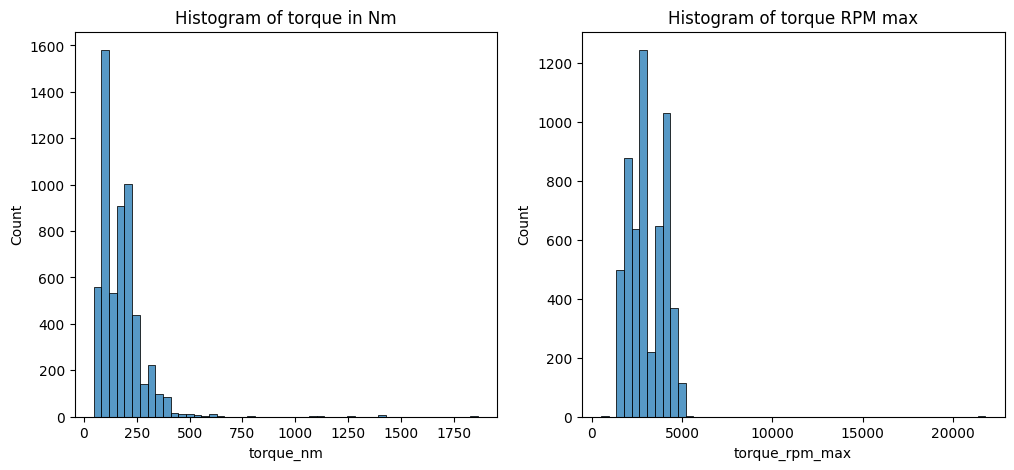

In [23]:
# histograms of the new torque_nm and torque_rpm_max columns
# (courtesy to copilot autocomplete []~(￣▽￣)~* )
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_train['torque_nm'].dropna(), bins=50, ax=axes[0])
axes[0].set_title('Histogram of torque in Nm')
sns.histplot(df_train['torque_rpm_max'].dropna(), bins=50, ax=axes[1])
axes[1].set_title('Histogram of torque RPM max')
plt.show()

In [24]:
# проверим что там за выбросы
display(df_train[(df_train['torque_nm'] > 1000) | (df_train['torque_rpm_max'] > 7000)][['torque', 'torque_nm', 'torque_rpm_max']])

# Оказалось, что ошибки в нашем конвертере нет, просто исходные данные такие, причём с явно указанными единицами.

torque   torque_nm  torque_rpm_max
498    115@ 2,500(kgm@ rpm)  1127.76475          2500.0
920    145@ 4,100(kgm@ rpm)  1421.96425          4100.0
1616   115@ 2,500(kgm@ rpm)  1127.76475          2500.0
1787   145@ 4,100(kgm@ rpm)  1421.96425          4100.0
1809   145@ 4,100(kgm@ rpm)  1421.96425          4100.0
1898    130@ 2500(kgm@ rpm)  1274.86450          2500.0
2242    130@ 2500(kgm@ rpm)  1274.86450          2500.0
3115   145@ 4,100(kgm@ rpm)  1421.96425          4100.0
3187   145@ 4,100(kgm@ rpm)  1421.96425          4100.0
3252    115@ 2500(kgm@ rpm)  1127.76475          2500.0
3370   145@ 4,100(kgm@ rpm)  1421.96425          4100.0
3607   115@ 2,500(kgm@ rpm)  1127.76475          2500.0
3614   145@ 4,100(kgm@ rpm)  1421.96425          4100.0
3621   110@ 3,000(kgm@ rpm)  1078.73150          3000.0
3650   145@ 4,100(kgm@ rpm)  1421.96425          4100.0
3810   115@ 2,500(kgm@ rpm)  1127.76475          2500.0
3936  190@ 21,800(kgm@ rpm)  1863.26350         21800.0
4102   145@ 4,100(kgm@ rpm)  1421.96425          4100.0
4910    130@ 2500(kgm@ rpm)  1274.86450          2500.0

In [25]:
# torque сконвертировали, теперь осталось mileage, engine и max_power
templates = set()
for value in df_train['mileage'].unique():
    template = fill_numbers_with_symbol(value)
    if template is not None:
        templates.add(template)

print(len(templates), "unique templates found in 'mileage' column:")
display(templates) # km/kg vs kmpl: как конвертировать? Можно например считать что 1 km/kg == 1 kmpl.

templates = set()
for value in df_train['engine'].unique():
    template = fill_numbers_with_symbol(value)
    if template is not None:
        templates.add(template)
print(len(templates), "unique templates found in 'engine' column:")
display(templates) # ура тут всё просто

templates = set()
for value in df_train['max_power'].unique():
    template = fill_numbers_with_symbol(value)
    if template is not None:
        templates.add(template)
print(len(templates), "unique templates found in 'max_power' column:")
display(templates) # ура тут всё просто

2 unique templates found in 'mileage' column:


{'• km/kg', '• kmpl'}

1 unique templates found in 'engine' column:


{'• CC'}

3 unique templates found in 'max_power' column:


{' bhp', '•', '• bhp'}

In [26]:
def convert_row(row):
    # using extract_unsigned_numbers_from_string()
    mileage_str = row['mileage']
    engine_str = row['engine']
    max_power_str = row['max_power']
    # mileage
    mileage_value = None
    if mileage_str is not None and not pd.isnull(mileage_str):
        numbers = extract_unsigned_numbers_from_string(mileage_str)
        if len(numbers) >= 1:
            mileage_value = numbers[0]
    # engine
    engine_value = None
    if engine_str is not None and not pd.isnull(engine_str):
        numbers = extract_unsigned_numbers_from_string(engine_str)
        if len(numbers) >= 1:
            engine_value = numbers[0]
    # max_power
    max_power_value = None
    if max_power_str is not None and not pd.isnull(max_power_str):
        numbers = extract_unsigned_numbers_from_string(max_power_str)
        if len(numbers) >= 1:
            max_power_value = numbers[0]
    return pd.Series({
        'mileage_num': mileage_value,
        'engine_num': engine_value,
        'max_power_num': max_power_value
    })
df_train[['mileage_num', 'engine_num', 'max_power_num']] = df_train.apply(convert_row, axis=1)
df_test[['mileage_num', 'engine_num', 'max_power_num']] = df_test.apply(convert_row, axis=1)
display(df_train[['mileage', 'mileage_num', 'engine', 'engine_num', 'max_power', 'max_power_num']].sample(20))

mileage  mileage_num   engine  engine_num   max_power  max_power_num
3746  18.16 kmpl        18.16  1196 CC      1196.0    86.8 bhp          86.80
3839  23.84 kmpl        23.84  1199 CC      1199.0      84 bhp          84.00
4749   24.0 kmpl        24.00  1199 CC      1199.0   83.81 bhp          83.81
4048  17.11 kmpl        17.11  1968 CC      1968.0  174.33 bhp         174.33
3996   16.8 kmpl        16.80  1493 CC      1493.0     110 bhp         110.00
160   19.44 kmpl        19.44   999 CC       999.0      75 bhp          75.00
830    16.8 kmpl        16.80  1405 CC      1405.0      68 bhp          68.00
4331   26.0 kmpl        26.00  1498 CC      1498.0    98.6 bhp          98.60
3034   18.9 kmpl        18.90  1197 CC      1197.0      82 bhp          82.00
5496  20.89 kmpl        20.89  1197 CC      1197.0   81.80 bhp          81.80
4342   15.3 kmpl        15.30  2956 CC      2956.0    83.8 bhp          83.80
4012  21.14 kmpl        21.14  1498 CC      1498.0  103.52 bhp         103.52
4434  20.77 kmpl        20.77  1248 CC      1248.0   88.76 bhp          88.76
200   20.51 kmpl        20.51   998 CC       998.0   67.04 bhp          67.04
1274  26.59 kmpl        26.59  1248 CC      1248.0      74 bhp          74.00
1887   21.1 kmpl        21.10   814 CC       814.0    55.2 bhp          55.20
357    28.4 kmpl        28.40  1248 CC      1248.0   74.02 bhp          74.02
3295  25.44 kmpl        25.44   936 CC       936.0    57.6 bhp          57.60
3897  21.04 kmpl        21.04  1461 CC      1461.0    83.8 bhp          83.80
1401  20.51 kmpl        20.51   998 CC       998.0   67.04 bhp          67.04

In [27]:
df_train_converted = df_train.drop(columns=['mileage', 'engine', 'max_power', 'torque'])
df_test_converted = df_test.drop(columns=['mileage', 'engine', 'max_power', 'torque'])

# Проверяем что всё красиво и столбцы на месте
display(df_train_converted.sample(3))
display(df_test_converted.sample(3))


name  year  selling_price  km_driven  \
4427  Hyundai i20 2015-2017 Sportz 1.4 CRDi  2017         650000      60000   
3295                  Chevrolet Beat Diesel  2012         135000      49000   
5764                    Maruti Alto 800 VXI  2016         320000      46737   

        fuel seller_type transmission        owner  seats  torque_nm  \
4427  Diesel  Individual       Manual  First Owner    5.0      219.7   
3295  Diesel  Individual       Manual  Third Owner    5.0      150.0   
5764  Petrol  Individual       Manual  First Owner    5.0       69.0   

      torque_rpm_max  mileage_num  engine_num  max_power_num  
4427          2750.0        22.54      1396.0          88.73  
3295          1750.0        25.44       936.0          57.60  
5764          3500.0        22.74       796.0          47.30

name  year  selling_price  km_driven    fuel  \
949           Toyota Camry 2.5 Hybrid  2016        2000000      68089  Petrol   
150               Maruti Alto 800 LXI  2013         200000      50000  Petrol   
964  Tata New Safari DICOR 2.2 VX 4x4  2009         380000     150000  Diesel   

          seller_type transmission        owner  seats  torque_nm  \
949  Trustmark Dealer    Automatic  First Owner    5.0      213.0   
150        Individual       Manual  First Owner    5.0       69.0   
964        Individual       Manual  First Owner    7.0      320.0   

     torque_rpm_max  mileage_num  engine_num  max_power_num  
949          4500.0        19.16      2494.0          157.7  
150          3500.0        22.74       796.0           47.3  
964          2700.0        13.93      2179.0          138.0

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [28]:
# filling the NaN values with the median of the respective columns
# (courtesy to copilot autocomplete φ(*￣0￣) )
for col in ['mileage_num', 'engine_num', 'max_power_num', 'torque_nm', 'torque_rpm_max', 'seats']:
    median_value_train = df_train_converted[col].median()
    # median_value_test = df_test_converted[col].median()
    df_train_converted[col] = df_train_converted[col].fillna(median_value_train)
    # df_test_converted[col] = df_test_converted[col].fillna(median_value_test) # Nope! :>
    df_test_converted[col] = df_test_converted[col].fillna(median_value_train) # пропуск это пропуск, и хэндлить его надо одинаково


In [29]:
# в целом любить медиану причин сильно больше чем среднее ٩(｡•́‿•̀｡)۶
# если какой-нибудь power law distribution или log-normal distribution -- "среднее" там всё только поломает
# получается такая вот "сглаженная мода" при assumption того, 
# что целевое распределение значений в природе теоретически гладкое (даже если в данных оно не сильно гладкое)

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [30]:
print(df_train_converted['seats'].unique()) # небольшое конечное уникальных вариантов seats = мог быть и категориальным признаком
# ( вообще теоретически ничего никогда не мешает говорить 
# что float64 столбцы это категориальные признаки 
# с приблизительно 2^64 числом категорий :D )

[ 5.  4.  7.  8.  6.  9. 10. 14.  2.]


In [31]:
df_train_converted['seats'] = df_train_converted['seats'].astype('Int64')
df_test_converted['seats'] = df_test_converted['seats'].astype('Int64')
display(df_train_converted.sample(3))
display(df_test_converted.sample(3))

name  year  selling_price  km_driven    fuel  \
3377  Maruti Wagon R LXI BSIII  2011         195000     120000  Petrol   
3315       Maruti SX4 Vxi BSIV  2012         260000      99000  Petrol   
4419       Honda City 1.5 S MT  2011         450000      80000  Petrol   

     seller_type transmission         owner  seats  torque_nm  torque_rpm_max  \
3377  Individual       Manual   First Owner      5       90.0          3500.0   
3315  Individual       Manual  Second Owner      5      145.0          4100.0   
4419  Individual       Manual   Third Owner      5      146.0          4800.0   

      mileage_num  engine_num  max_power_num  
3377         18.9       998.0           67.1  
3315         15.5      1586.0          103.3  
4419         17.0      1497.0          118.0

name  year  selling_price  \
306               Mahindra Bolero Power Plus ZLX  2019         740000   
974  Toyota Innova 2.5 G (Diesel) 8 Seater BS IV  2005         310000   
754  Ford EcoSport 1.5 Diesel Titanium Plus BSIV  2017         850000   

     km_driven    fuel seller_type transmission         owner  seats  \
306      14000  Diesel  Individual       Manual   First Owner      7   
974     200000  Diesel  Individual       Manual  Second Owner      8   
754      76139  Diesel  Individual       Manual   First Owner      5   

     torque_nm  torque_rpm_max  mileage_num  engine_num  max_power_num  
306  195.00000          2200.0         16.5      1493.0          70.00  
974  200.05566          3400.0         12.8      2494.0         102.00  
754  205.00000          3250.0         23.0      1498.0          98.96

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [32]:
display(Markdown("**Статистики (как категориальные так и числовые) по данным (train сплит):**"))
display(df_train_converted.describe(include='all'))

display(Markdown("**Статистики (как категориальные так и числовые) по данным (test сплит):**"))
display(df_test_converted.describe(include='all'))

# relative difference of every numerical statistic from .describe() between train and test splits
# (courtesy to copilot autocomplete (✿◡‿◡) )
use_cols = df_train_converted.select_dtypes(include=[np.number]).columns
train_desc = df_train_converted[use_cols].describe().T.drop(columns=['count', 'min', 'max', 'unique', 'top', 'freq'], errors='ignore')
test_desc = df_test_converted[use_cols].describe().T.drop(columns=['count', 'min', 'max', 'unique', 'top', 'freq'], errors='ignore')
rel_diff = (train_desc - test_desc).abs() / (train_desc.abs() + test_desc.abs()) / 2 * 100
rel_diff = rel_diff[['mean', 'std', '25%', '50%', '75%']]
display(Markdown("*Относительные различия числовых статистик между train и test сплитами __(в процентах)__:*"))
display(rel_diff)

**Статистики (как категориальные так и числовые) по данным (train сплит):**

name         year  selling_price     km_driven  \
count                     5840  5840.000000   5.840000e+03  5.840000e+03   
unique                    1924          NaN            NaN           NaN   
top     Maruti Swift Dzire VDI          NaN            NaN           NaN   
freq                        91          NaN            NaN           NaN   
mean                       NaN  2013.428425   5.229601e+05  7.395224e+04   
std                        NaN     4.095622   5.354320e+05  6.007114e+04   
min                        NaN  1983.000000   2.999900e+04  1.000000e+00   
25%                        NaN  2011.000000   2.500000e+05  3.900000e+04   
50%                        NaN  2014.000000   4.050000e+05  7.000000e+04   
75%                        NaN  2017.000000   6.400000e+05  1.000000e+05   
max                        NaN  2020.000000   1.000000e+07  2.360457e+06   

          fuel seller_type transmission        owner     seats    torque_nm  \
count     5840        5840         5840         5840    5840.0  5840.000000   
unique       4           3            2            5      <NA>          NaN   
top     Diesel  Individual       Manual  First Owner      <NA>          NaN   
freq      3177        5223         5336         3603      <NA>          NaN   
mean       NaN         NaN          NaN          NaN  5.426712   175.357443   
std        NaN         NaN          NaN          NaN  0.982344   107.145160   
min        NaN         NaN          NaN          NaN       2.0    47.071920   
25%        NaN         NaN          NaN          NaN       5.0   111.800000   
50%        NaN         NaN          NaN          NaN       5.0   160.000000   
75%        NaN         NaN          NaN          NaN       5.0   200.055660   
max        NaN         NaN          NaN          NaN      14.0  1863.263500   

        torque_rpm_max  mileage_num   engine_num  max_power_num  
count      5840.000000  5840.000000  5840.000000    5840.000000  
unique             NaN          NaN          NaN            NaN  
top                NaN          NaN          NaN            NaN  
freq               NaN          NaN          NaN            NaN  
mean       3046.132021    19.430841  1429.448973      87.906371  
std         912.664032     3.985973   485.662834      31.640418  
min         503.000000     0.000000   624.000000       0.000000  
25%        2250.000000    16.950000  1197.000000      68.000000  
50%        3000.000000    19.370000  1248.000000      81.860000  
75%        4000.000000    22.300000  1498.000000      99.000000  
max       21800.000000    42.000000  3604.000000     400.000000

**Статистики (как категориальные так и числовые) по данным (test сплит):**

name         year  selling_price      km_driven  \
count                  1000  1000.000000   1.000000e+03    1000.000000   
unique                  621          NaN            NaN            NaN   
top     Maruti Alto 800 LXI          NaN            NaN            NaN   
freq                     15          NaN            NaN            NaN   
mean                    NaN  2013.681000   6.179010e+05   71393.341000   
std                     NaN     4.012149   7.585539e+05   48486.218662   
min                     NaN  1995.000000   3.100000e+04    1303.000000   
25%                     NaN  2011.000000   2.500000e+05   37000.000000   
50%                     NaN  2014.000000   4.349990e+05   61500.000000   
75%                     NaN  2017.000000   6.700000e+05  100000.000000   
max                     NaN  2020.000000   6.000000e+06  375000.000000   

          fuel seller_type transmission        owner     seats    torque_nm  \
count     1000        1000         1000         1000    1000.0  1000.000000   
unique       4           3            2            5      <NA>          NaN   
top     Diesel  Individual       Manual  First Owner      <NA>          NaN   
freq       534         837          877          623      <NA>          NaN   
mean       NaN         NaN          NaN          NaN     5.403   177.617377   
std        NaN         NaN          NaN          NaN  0.912921   103.734516   
min        NaN         NaN          NaN          NaN       4.0    48.000000   
25%        NaN         NaN          NaN          NaN       5.0   111.700000   
50%        NaN         NaN          NaN          NaN       5.0   160.000000   
75%        NaN         NaN          NaN          NaN       5.0   205.000000   
max        NaN         NaN          NaN          NaN       9.0  1421.964250   

        torque_rpm_max  mileage_num  engine_num  max_power_num  
count      1000.000000   1000.00000  1000.00000    1000.000000  
unique             NaN          NaN         NaN            NaN  
top                NaN          NaN         NaN            NaN  
freq               NaN          NaN         NaN            NaN  
mean       3096.779000     19.33881  1454.87600      90.841670  
std         882.282899      3.95175   521.99574      34.893389  
min         503.000000      0.00000   624.00000      34.200000  
25%        2500.000000     16.55000  1197.00000      69.000000  
50%        3000.000000     19.37000  1248.00000      82.425000  
75%        4000.000000     22.30000  1582.00000     102.000000  
max        5200.000000     32.26000  3604.00000     280.000000

*Относительные различия числовых статистик между train и test сплитами __(в процентах)__:*

mean       std       25%       50%       75%
year            0.003136  0.514774       0.0       0.0       0.0
selling_price   4.160934  8.621495       0.0  1.785657  1.145038
km_driven       0.880282  5.335851  1.315789  3.231939       0.0
seats           0.109478  1.831489       0.0       0.0       0.0
torque_nm       0.320127  0.808671  0.022371       0.0  0.610328
torque_rpm_max  0.412239  0.846296  2.631579       0.0       0.0
mileage_num     0.118689  0.215572  0.597015       0.0       0.0
engine_num       0.44078  1.802838       0.0       0.0  1.363636
max_power_num   0.821072    2.4446  0.364964  0.171957  0.746269

In [33]:
# Вау, разница mean меньше процента везде кроме целевой переменной.
# Хотя тут и правда может заметно сказываться то, что мы заполняли все пропуски медианой из трейна.
# Основание так полагать? Медиана (50% квантиль) в точности одинаковая между сплитами во многих столбцах.

# Но радует что квартили 25% и 75% тоже близки между сплитами.

# Плюс наверное хорошим признаком можно считать
# что категориальные признаки fuel_type, seller_type, transmission, owner
# имеют одну и ту же моду между сплитами.


## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

<Figure size 1000x600 with 0 Axes>

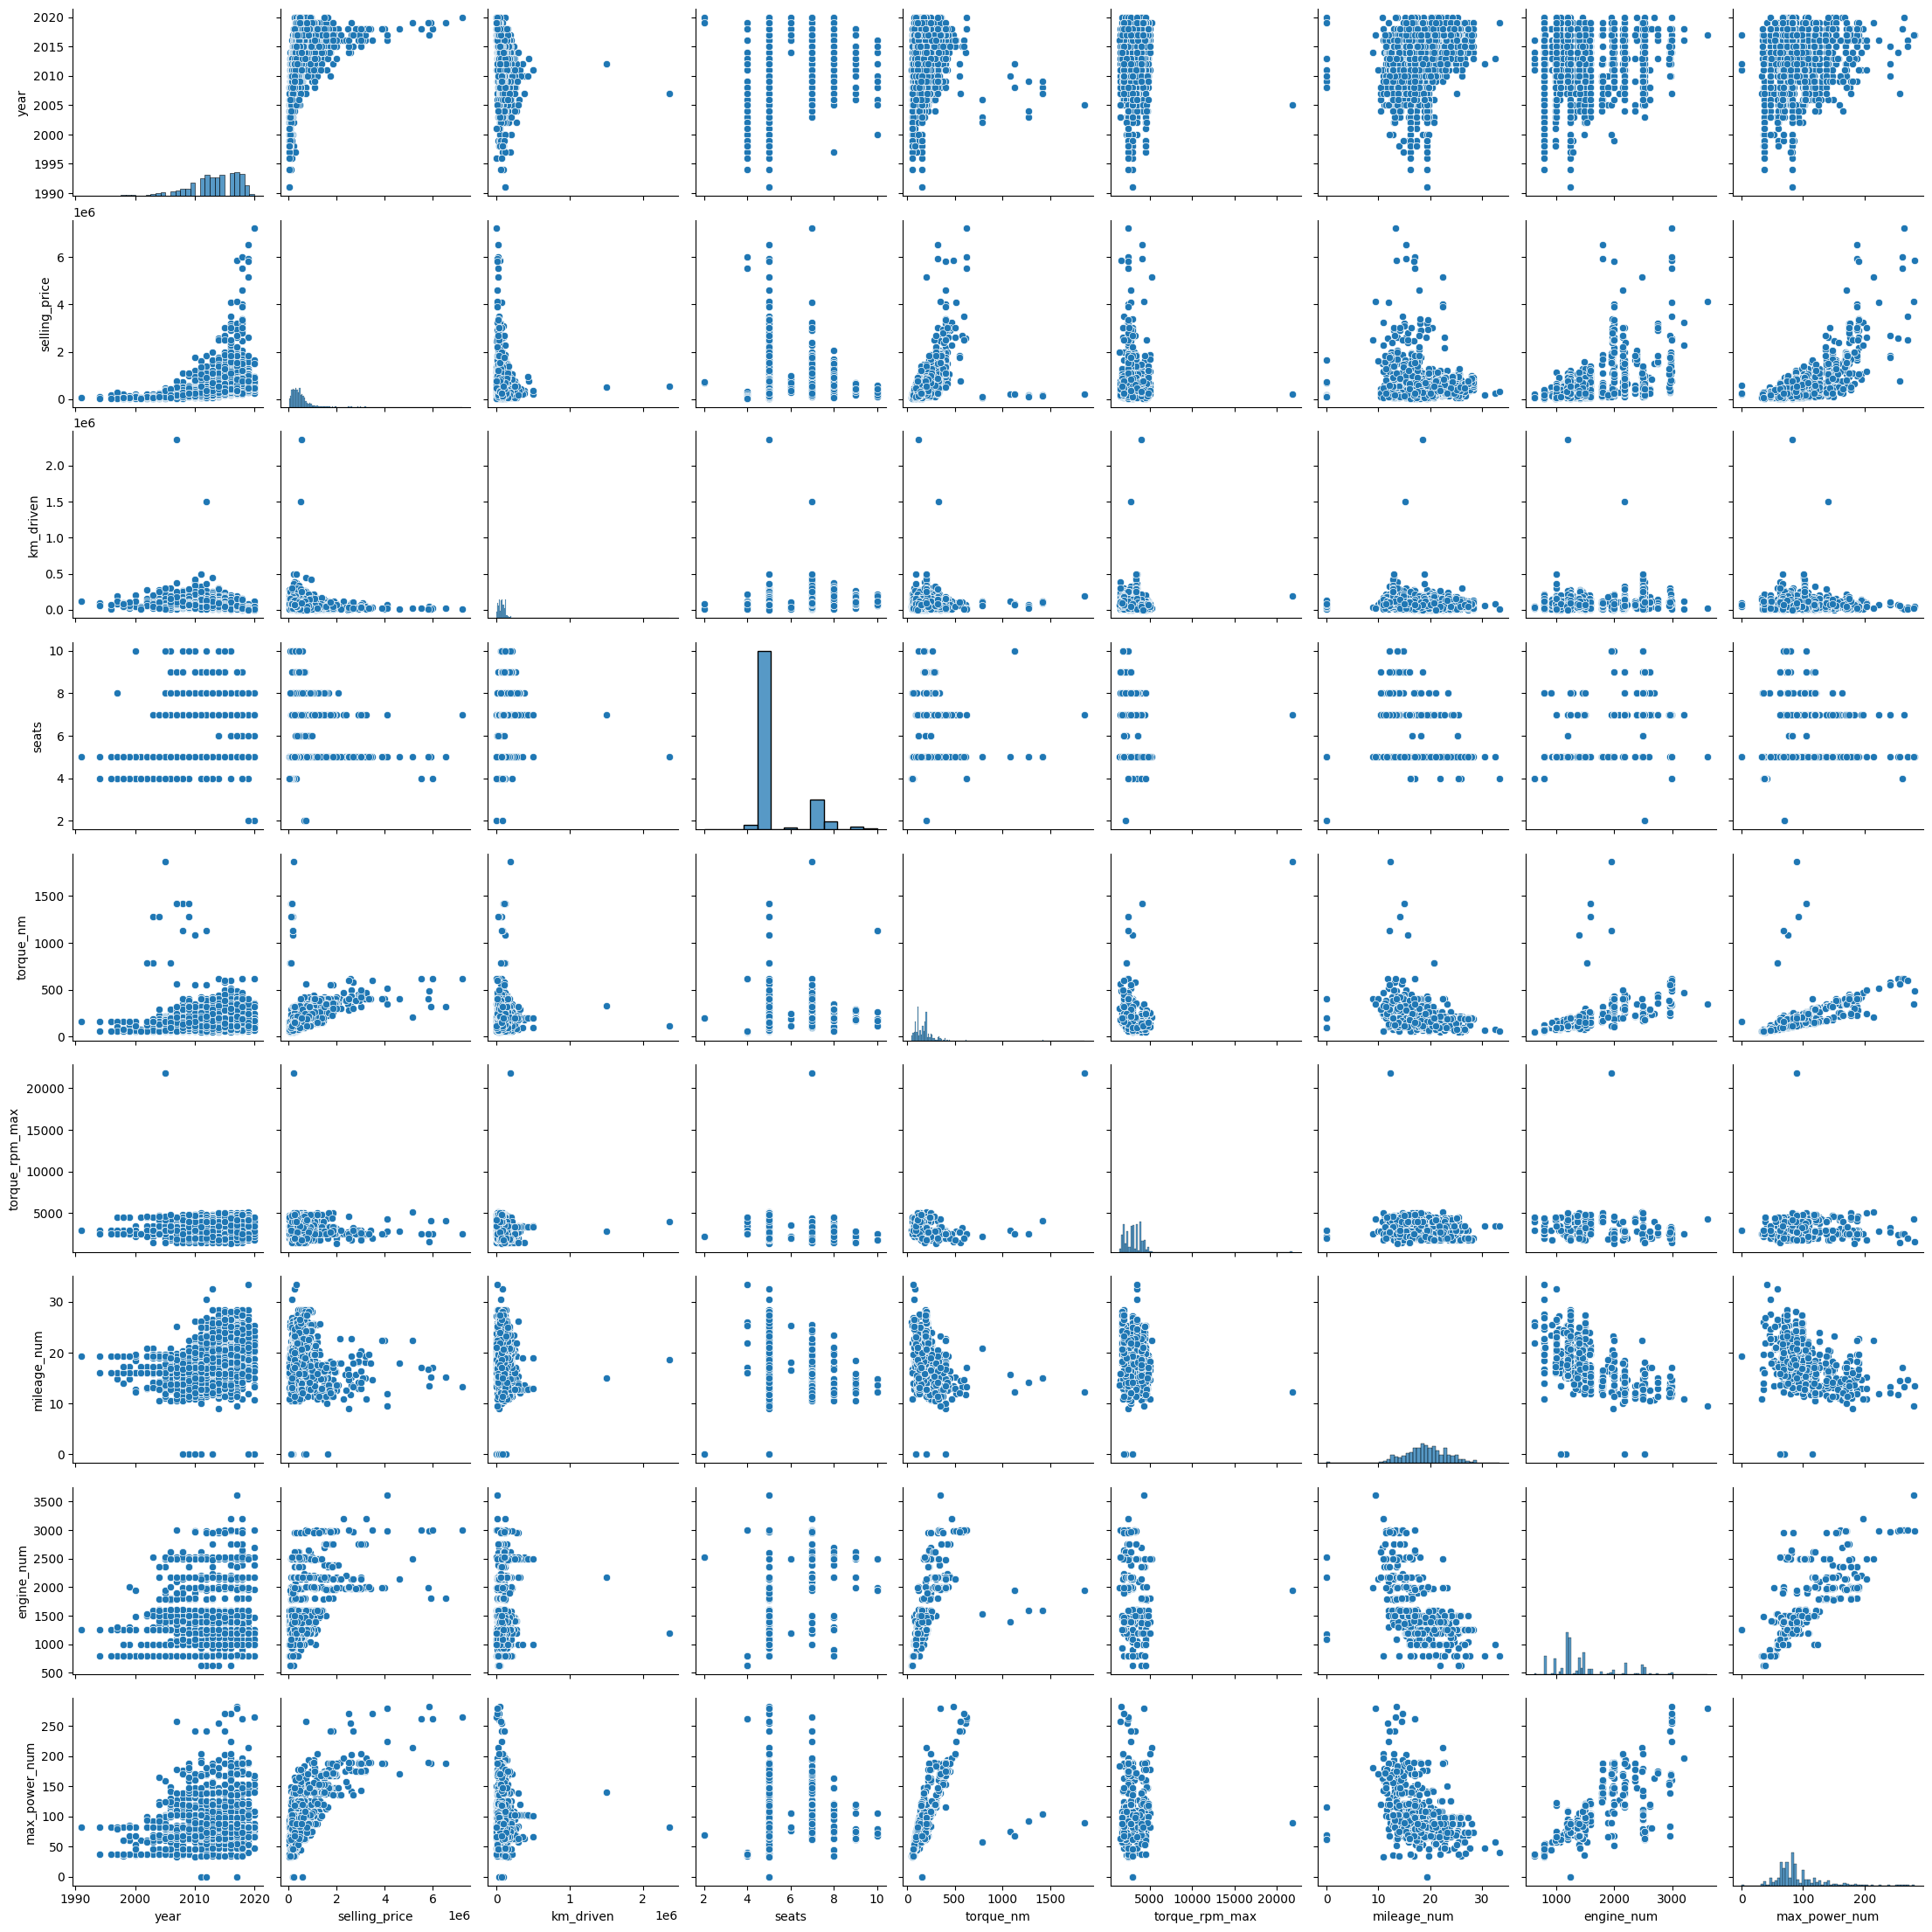

In [34]:
plt.figure(figsize=(10, 6))
sns.pairplot(df_train_converted.sample(frac=0.5, random_state=123))
plt.show()

# связь selling_price c year, km_driven, torque_nm, engine_num, max_power_num -- да
# связь с mileage, torque_rpm_max -- сложно сказать, скорее нет чем да

# да, некоторые корреляции между признаками видны -- можно выдвигать гипотезы "глазами"

<Figure size 1000x600 with 0 Axes>

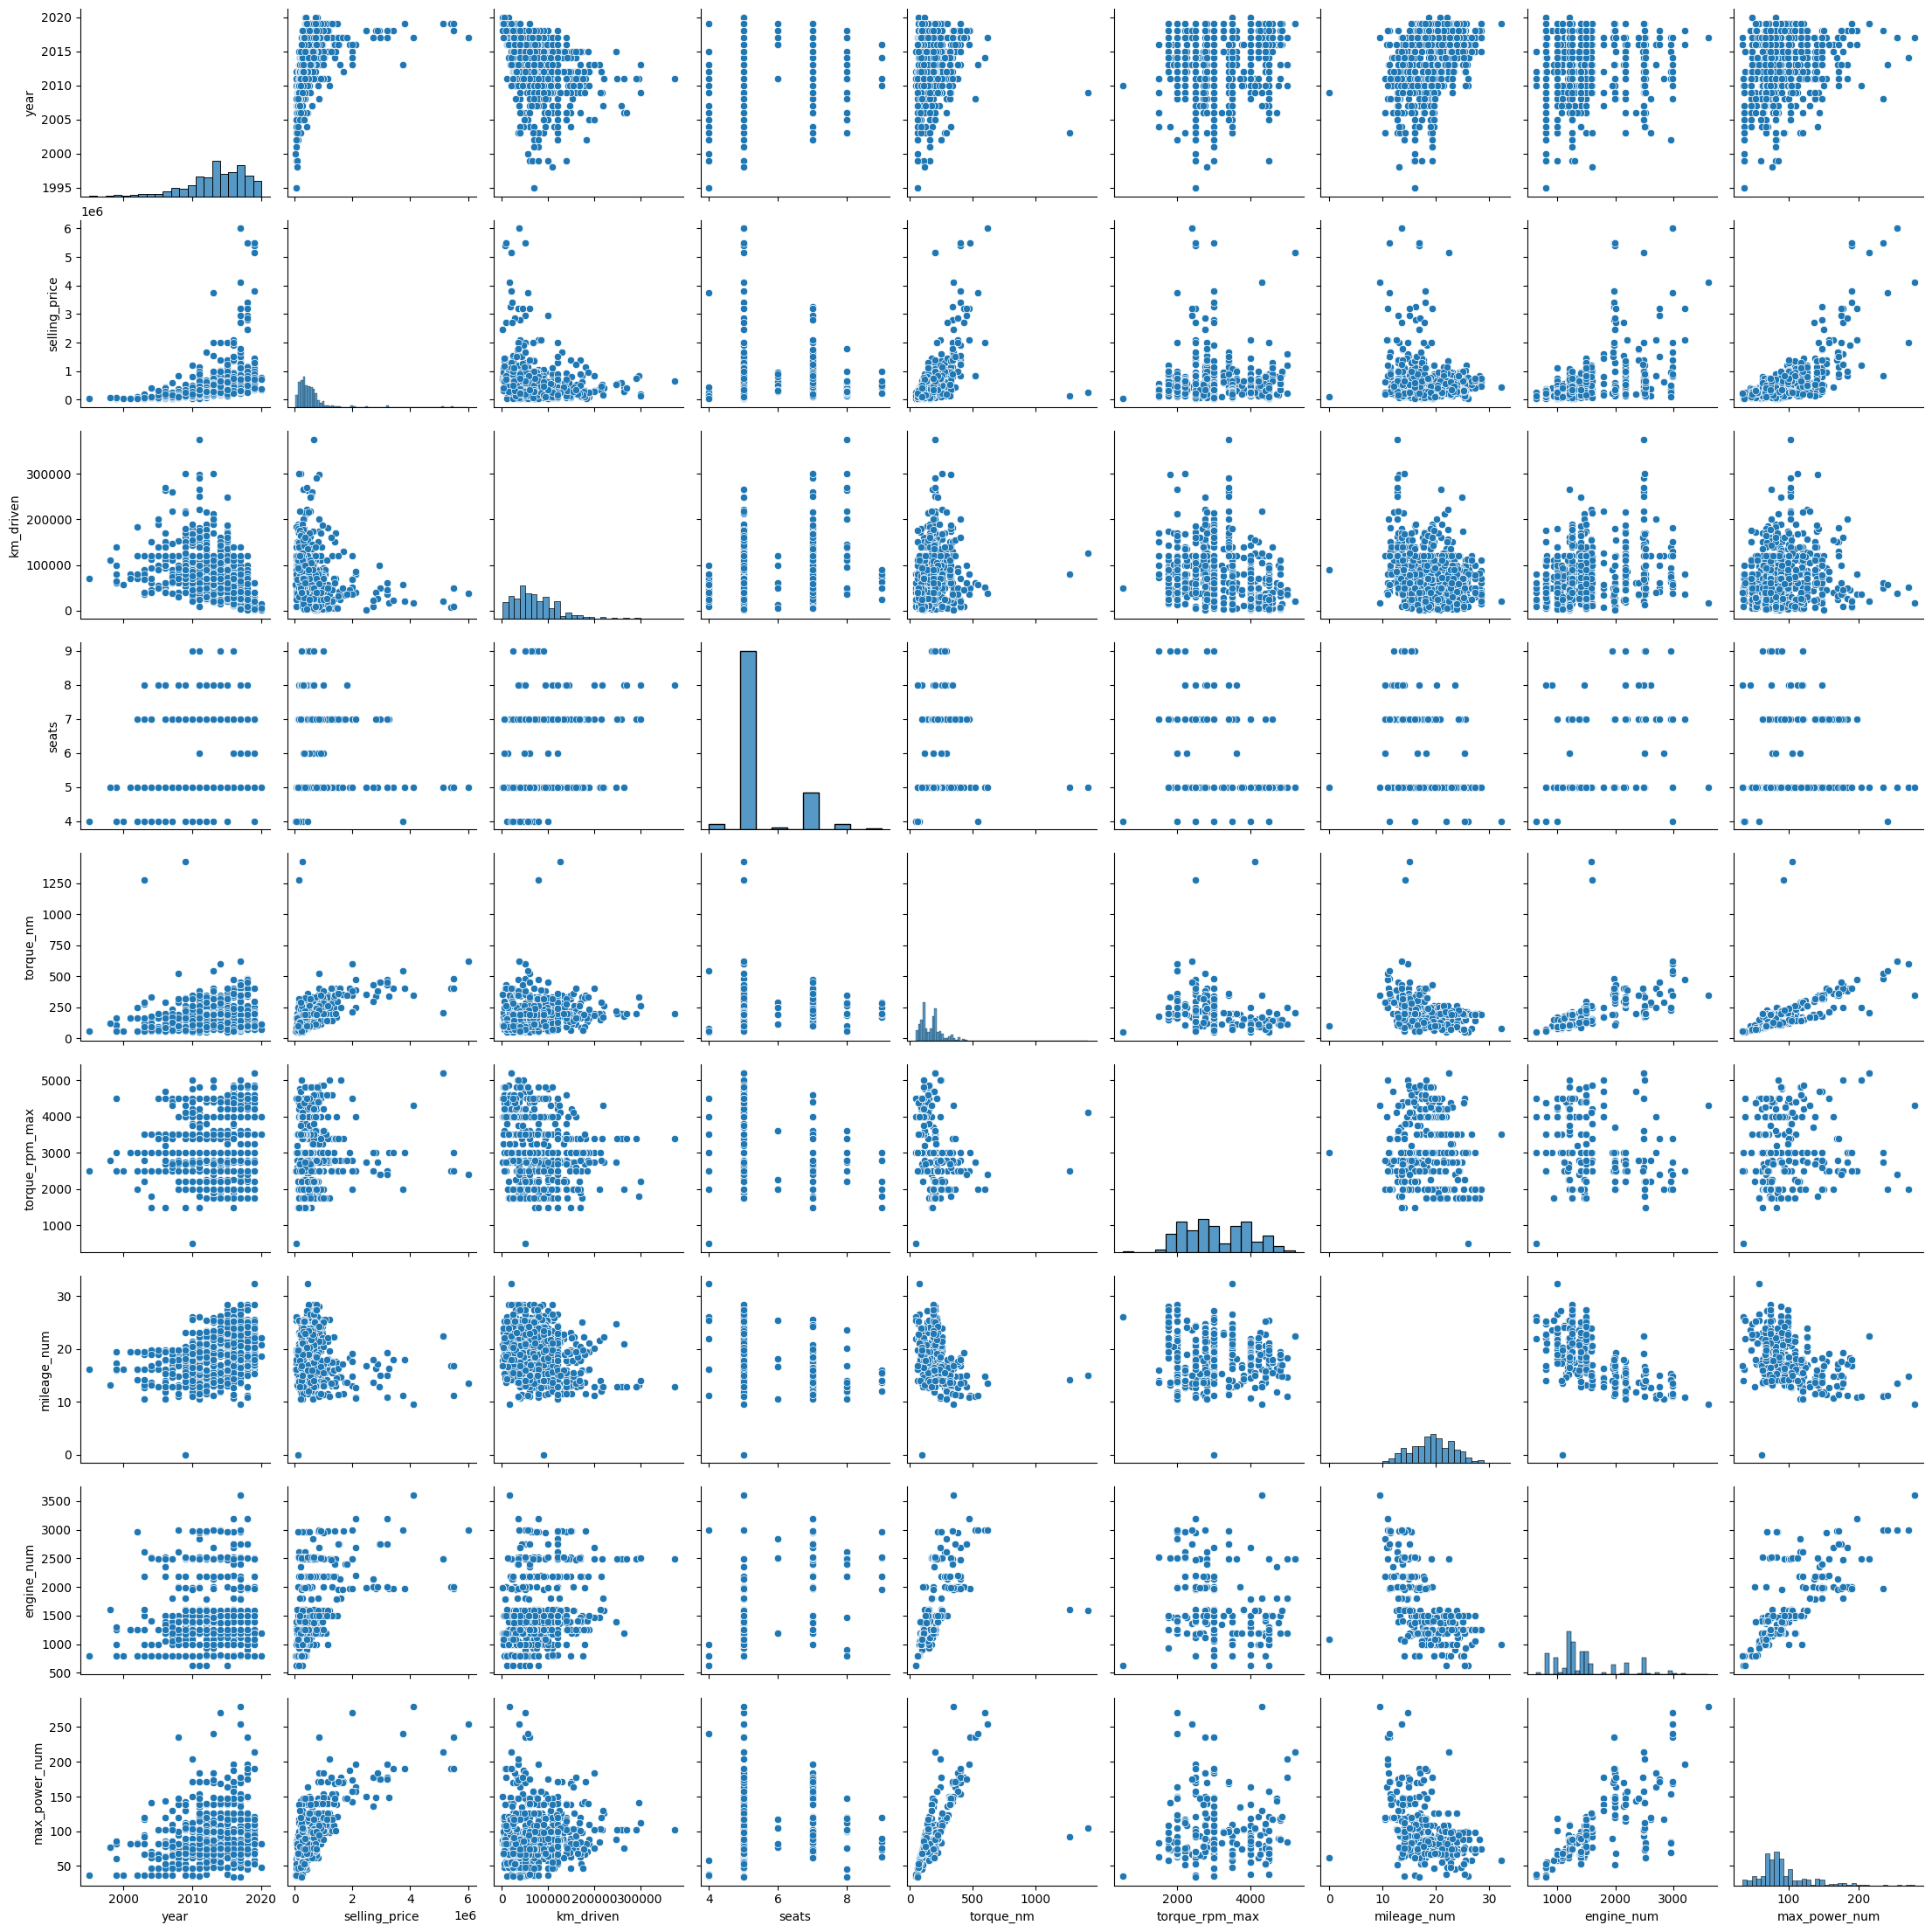

In [35]:
plt.figure(figsize=(10, 6))
sns.pairplot(df_test_converted.sample(frac=1.0))
plt.show()

# с поправкой на outlier'ы из torque, распределения очень похожи.

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

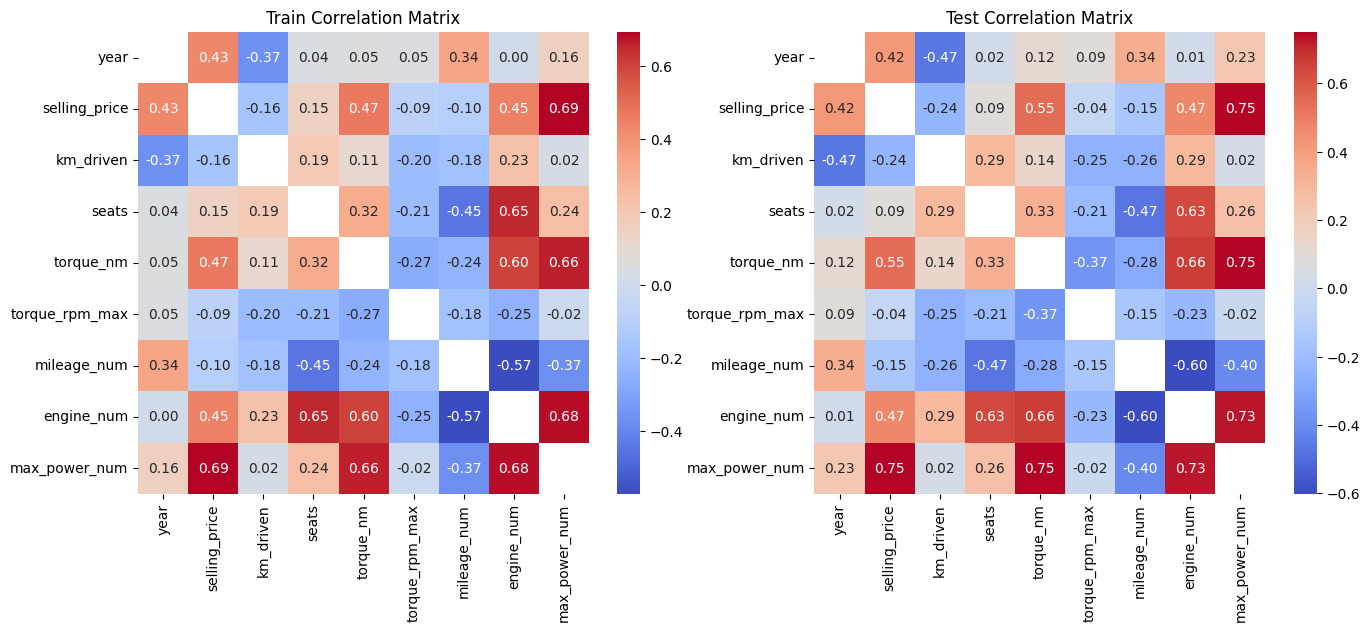

In [36]:
# only using numerical columns for correlation matrix
# (courtesy to copilot autocomplete ʕ•ᴥ•ʔ )
only_numerical_cols = df_train_converted.select_dtypes(include=[np.number]).columns

# manual code here
train_corr = df_train_converted[only_numerical_cols].corr()
np.fill_diagonal(train_corr.values, np.nan)

test_corr = df_test_converted[only_numerical_cols].corr()
np.fill_diagonal(test_corr.values, np.nan)

# autocomplete code here
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(train_corr, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
axes[0].set_title("Train Correlation Matrix")
sns.heatmap(test_corr, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
axes[1].set_title("Test Correlation Matrix")
plt.show()

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

In [37]:
# Какие 2 признака наименее скоррелированы между собой?
# Где? В трейне?
# В трейне -- engine+year

# Между какими наблюдается довольно сильная положительная линейная зависимость?
# max_power + selling_price
# max_power + engine
# max_power + torque_nm
# engine + seats
# engine + torque_nm

# Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
# Похоже, что правильно.

# Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?
# По умолчанию используется корреляция Пирсона.
# Мне больше нравится Спирмана -- не вижу недостатков по сравнению с Пирсоном вообще ни в каком частном случае.
# (плюс I'm biased потому что я независимо придумал перцентильную корреляцию до того как узнал что у неё уже есть название :D)


### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ] Сделайте выводы


Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


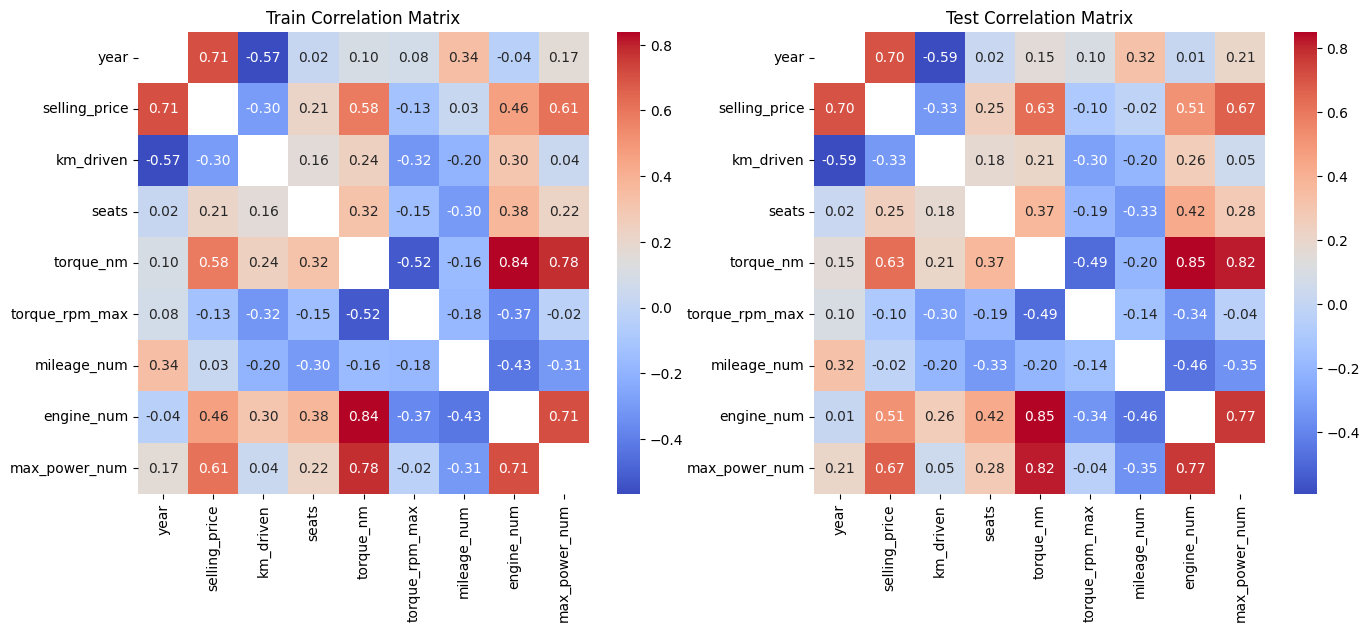

In [38]:
def convert_to_percentile_ranks(df):
    df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        col_values = df[col].to_numpy()
        ranks = col_values.argsort().argsort() # дважды argsort чтобы получить ранги
        percentile_ranks = ranks / (len(col_values) - 1) # перцентили из рангов
        df[col] = percentile_ranks
    return df

df_train_percentile = convert_to_percentile_ranks(df_train_converted)
df_test_percentile = convert_to_percentile_ranks(df_test_converted)

# получится корреляция Спирмана
train_corr_spearman = df_train_percentile[only_numerical_cols].corr()
np.fill_diagonal(train_corr_spearman.values, np.nan)

test_corr_spearman = df_test_percentile[only_numerical_cols].corr()
np.fill_diagonal(test_corr_spearman.values, np.nan)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(train_corr_spearman, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
axes[0].set_title("Train Correlation Matrix")
sns.heatmap(test_corr_spearman, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
axes[1].set_title("Test Correlation Matrix")
plt.show()

In [39]:
# Выводы? imo Спирман чище. Всегда.
# Иллюстративный пример -- увеличилась корреляция между selling_price и year, потому что там монотонности больше чем линейности.
# Аналогично с selling_price и km_driven -- там заметно уменьшилось то что было отрицательным.
# Всчкие ослабления корреляций не перечисляю, тут и так понятно.

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'torque_nm', 'torque_rpm_max', 'mileage_num', 'engine_num', 'max_power_num']


c:\Users\N\repos\exllamav2\venv\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable name is large: 1924. Are you sure this is not an interval variable? Analysis for pairs of variables including name can be slow.
  warnings.warn(


<Figure size 1400x1000 with 0 Axes>

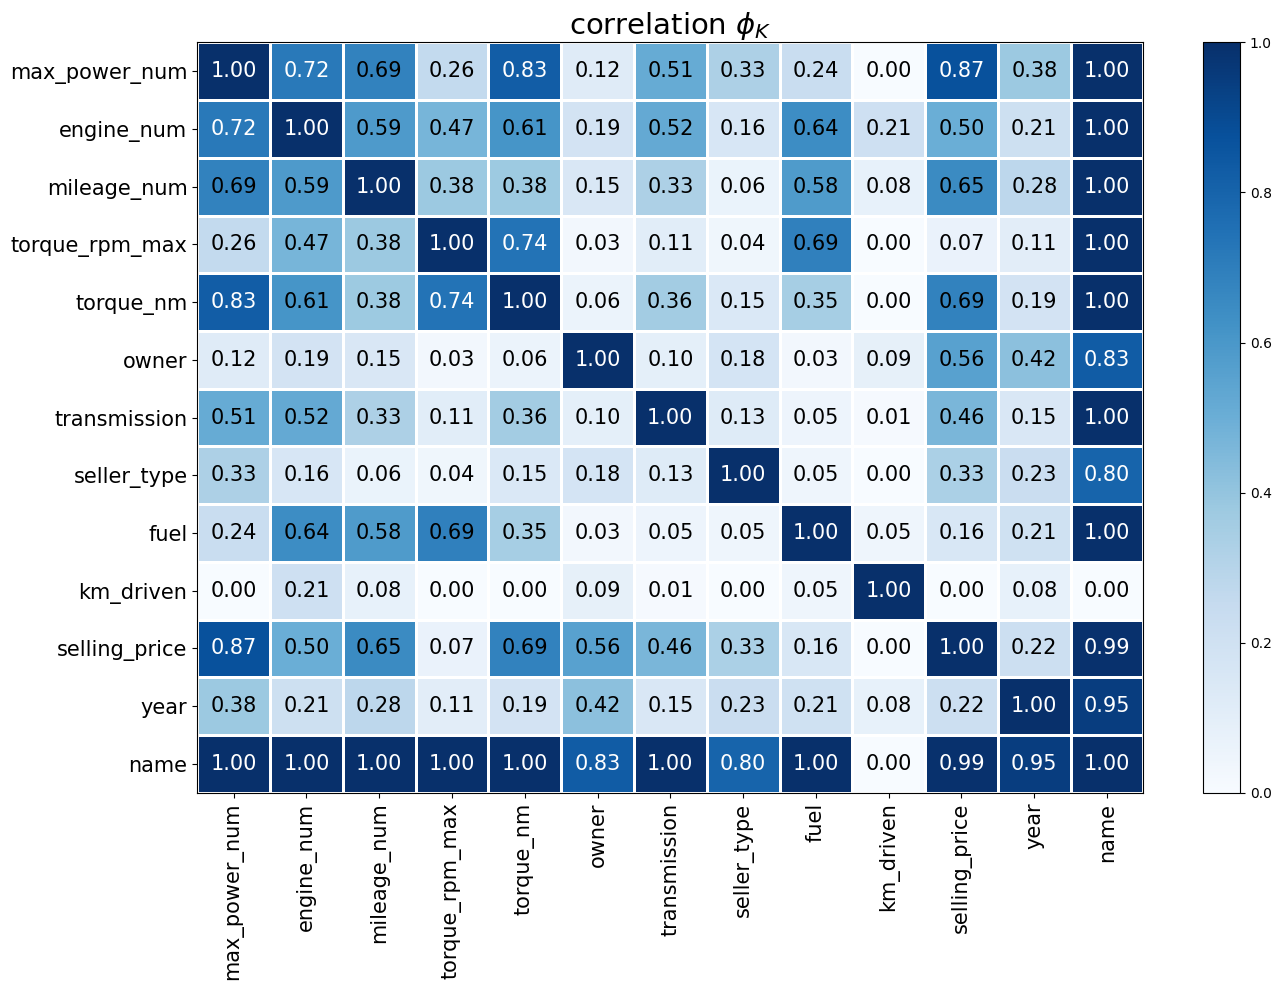

In [40]:
phik_overview = df_train_converted.drop(columns=['seats']).phik_matrix()
plt.figure(figsize=(14,10))
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(14,10))
plt.tight_layout()
plt.show()

In [41]:
# Выводы? Обычные.
# А интересные выводы? phik умеет считать корреляции между категориальными и числовыми признаками.
# Например, fuel и torque_rpm_max -- наверное, там нашлась общая зависимость от типа машины (грузовая/легковая).

### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

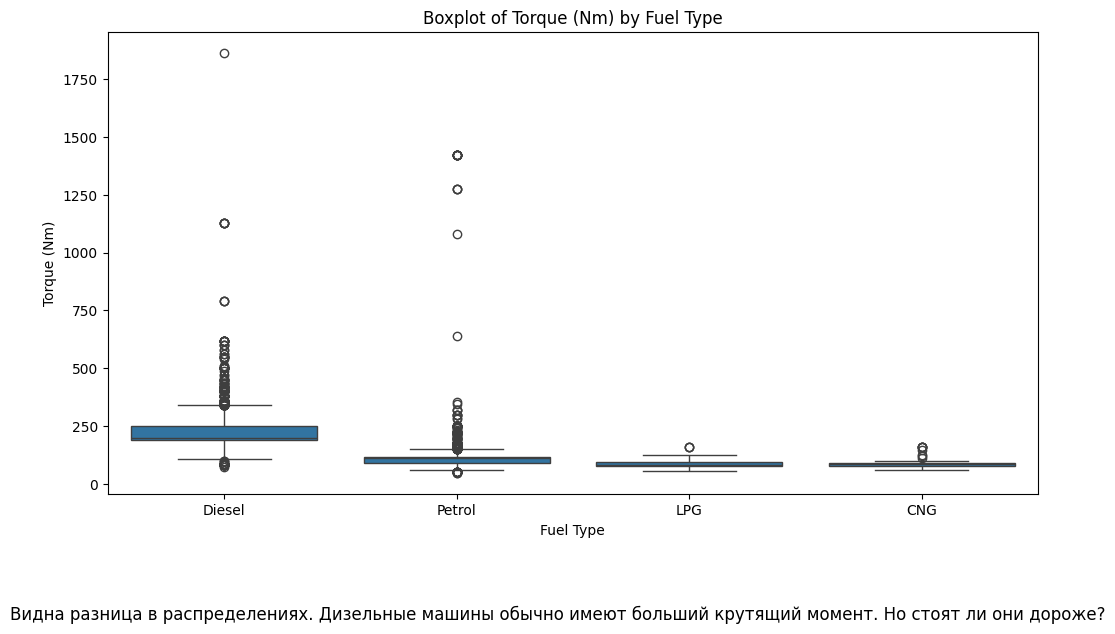

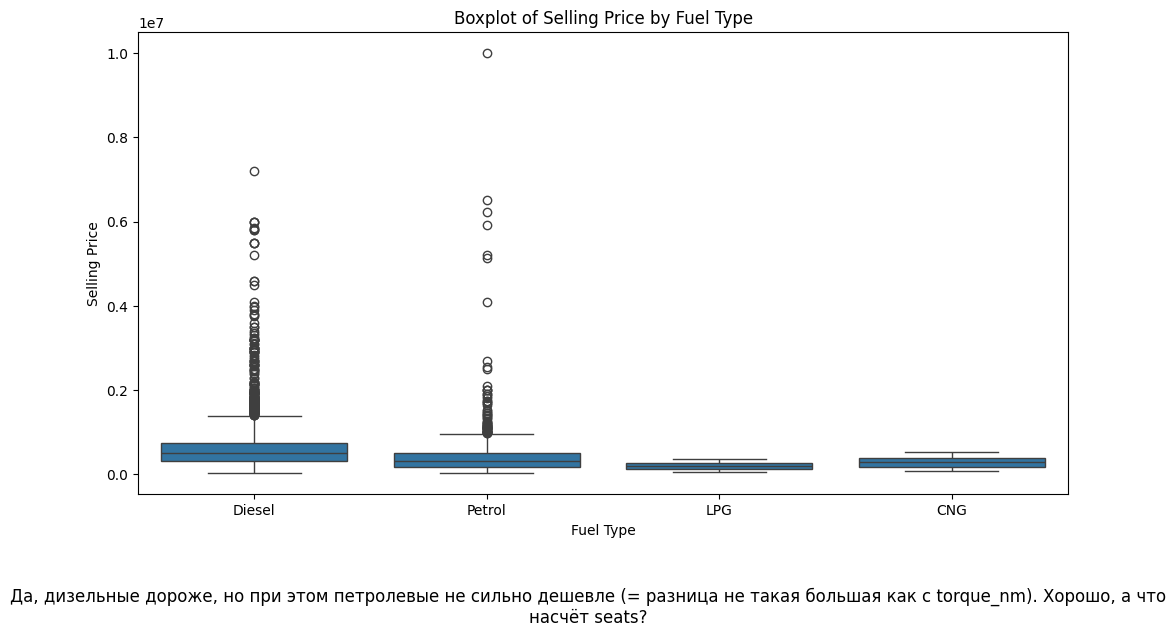

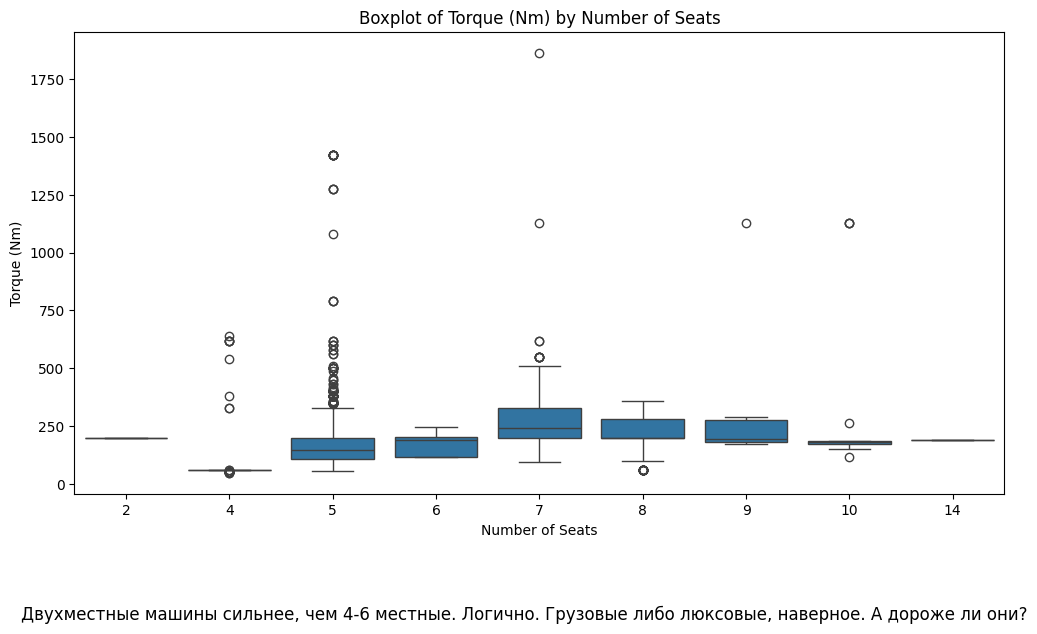

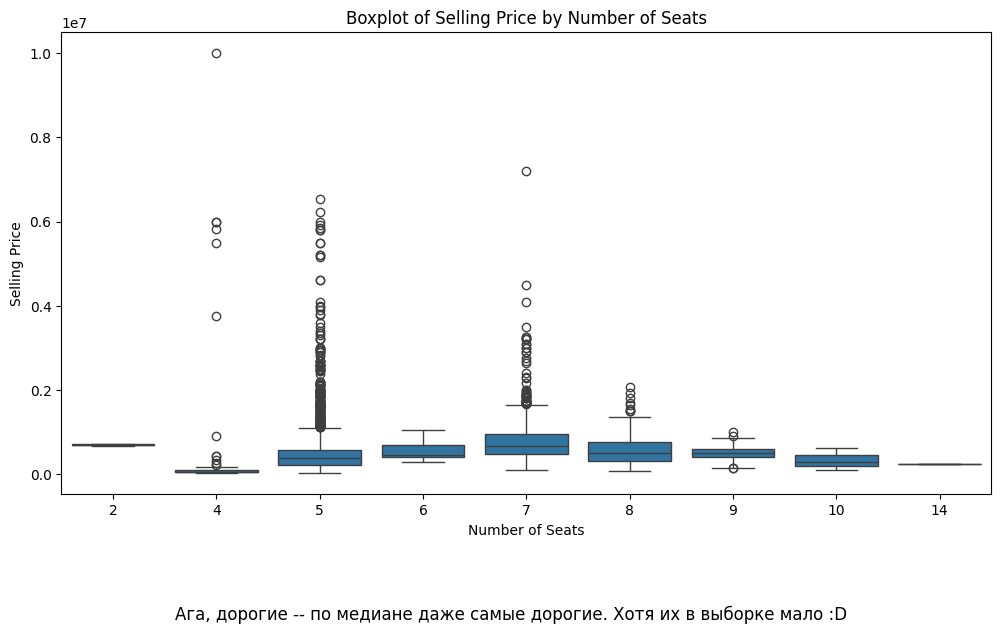

In [42]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='fuel', y='torque_nm', data=df_train_converted)
plt.title('Boxplot of Torque (Nm) by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Torque (Nm)')
plt.figtext(0.5, -0.1, "Видна разница в распределениях. Дизельные машины обычно имеют больший крутящий момент. Но стоят ли они дороже?", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='fuel', y='selling_price', data=df_train_converted)
plt.title('Boxplot of Selling Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Selling Price')
plt.figtext(0.5, -0.1, "Да, дизельные дороже, но при этом петролевые не сильно дешевле (= разница не такая большая как с torque_nm). Хорошо, а что насчёт seats?", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='seats', y='torque_nm', data=df_train_converted)
plt.title('Boxplot of Torque (Nm) by Number of Seats')
plt.xlabel('Number of Seats')
plt.ylabel('Torque (Nm)')
plt.figtext(0.5, -0.1, "Двухместные машины сильнее, чем 4-6 местные. Логично. Грузовые либо люксовые, наверное. А дороже ли они?", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='seats', y='selling_price', data=df_train_converted)
plt.title('Boxplot of Selling Price by Number of Seats')
plt.xlabel('Number of Seats')
plt.ylabel('Selling Price')
plt.figtext(0.5, -0.1, "Ага, дорогие -- по медиане даже самые дорогие. Хотя их в выборке мало :D", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()


# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Сделайте на тренировочный и тестовый наборы. Она уже даны, достаточно просто отделить целевой признак. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных. Используйте уже имеющиеся данные train и test. Если считаете уместным применить какую-то более хитрую технику разбиения — примените, но опишите, зачем.

In [43]:
df_train_only_numeric = df_train_converted.select_dtypes(include=[np.number]).copy()
df_test_only_numeric = df_test_converted.select_dtypes(include=[np.number]).copy()

X_train = df_train_only_numeric.drop(columns=['selling_price'])
y_train = df_train_only_numeric['selling_price']

X_test = df_test_only_numeric.drop(columns=['selling_price'])
y_test = df_test_only_numeric['selling_price']


In [44]:
X_train.head(3)

year  km_driven  seats  torque_nm  torque_rpm_max  mileage_num  engine_num  \
0  2014     145500      5  190.00000          2000.0        23.40      1248.0   
1  2014     120000      5  250.00000          2500.0        21.14      1498.0   
2  2010     127000      5  219.66896          2750.0        23.00      1396.0   

   max_power_num  
0          74.00  
1         103.52  
2          90.00

In [45]:
# опишите выбранные вещественные признаки

# 'year', 'km_driven', 'seats', 'torque_nm', 'torque_rpm_max', 'mileage_num', 'engine_num', 'max_power_num'

# year = год
# km_driven = пробег
# seats = количество сидячих мест
# torque_num = сила вращения
# torque_rpm_max = максимальная скорость вращения
# # mileage_num = расход топлива?
# engine_num = что-то про двигатель
# max_power_num = максимальная сила двигателя? bph = bsomething horse power?


### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE
import math

linreg_numeric_only_unscaled = LinearRegression()
linreg_numeric_only_unscaled.fit(X_train, y_train)


LinearRegression()

In [47]:
def evaluate_model(model, X, y, split_name="tsomthing"):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    mse = MSE(y, y_pred)
    rmse = math.sqrt(mse)
    print(f"{split_name}:\t\t R^2: {r2:.4f},\t\t MSE: {rmse:.0f} ^ 2")

def print_coefficients(model, feature_names):
    coeffs = model.coef_
    for feature, coeff in zip(feature_names, coeffs):
        print(f"{feature}: {coeff:.4f}")

In [48]:
evaluate_model(linreg_numeric_only_unscaled, X_train, y_train, "Train")
evaluate_model(linreg_numeric_only_unscaled, X_test, y_test, "Test")


Train:		 R^2: 0.6011,		 MSE: 338145 ^ 2
Test:		 R^2: 0.6004,		 MSE: 479260 ^ 2


### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [49]:
y_train_pred = linreg_numeric_only_unscaled.predict(X_train)
numerator = np.sum((y_train - y_train_pred) ** 2) # квадраты ошибки в числителе
denominator = np.sum((y_train - np.mean(y_train)) ** 2) # квадраты само-отклонения в знаменателе
r2_train_manual = 1 - (numerator / denominator)
print(f"Train R2: {r2_train_manual:.4f}")

Train R2: 0.6011


### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [50]:
n = X_train.shape[0]  # number of observations
p = X_train.shape[1]  # number of predictors
r2_train_adj = 1 - (1 - r2_train_manual) * (n - 1) / (n - p - 1) # courtesy to copilot autocomplete ~(>_<。)＼
print(f"Adjusted Train R2: {r2_train_adj:.4f}")

# adjusted чтобы количество факторов не влияло на R2
# применяется несмещенная оценка дисперсии

Adjusted Train R2: 0.6005


### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [52]:
display(pd.DataFrame(X_train_scaled).sample(3))
display(pd.DataFrame(X_test_scaled).describe().loc[['mean', 'std']])


0         1         2         3         4         5         6  \
2346  0.872122 -0.731733 -0.434419 -0.566172  1.045236 -0.208459 -0.478663   
1793 -0.348799 -0.398765 -0.434419 -0.796721  0.497343  0.373632 -0.888447   
618  -2.058087  1.266070 -0.434419 -1.058071 -0.050551  0.067532 -1.304409   

             7  
2346 -0.192061  
1793 -0.657645  
618  -1.315088

0         1         2         3         4         5         6  \
mean  0.061675 -0.042602 -0.024141  0.021094  0.055498 -0.023091  0.052360   
std   0.979703  0.807216  0.929409  0.968251  0.966794  0.991499  1.074903   

             7  
mean  0.092779  
std   1.102905

In [53]:
linreg_numeric_only_scaled = LinearRegression()
linreg_numeric_only_scaled.fit(X_train_scaled, y_train)

evaluate_model(linreg_numeric_only_scaled, X_train_scaled, y_train, "Scaled Train")
evaluate_model(linreg_numeric_only_scaled, X_test_scaled, y_test, "Scaled Test")

Scaled Train:		 R^2: 0.6011,		 MSE: 338145 ^ 2
Scaled Test:		 R^2: 0.6004,		 MSE: 479260 ^ 2


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [54]:
# printing coefficients
print_coefficients(linreg_numeric_only_scaled, X_train.columns)

# year: 165625.3464
# km_driven: -48925.4638
# seats: -30410.5212
# torque_nm: 7963.1372
# torque_rpm_max: -58671.6533
# mileage_num: -8328.2665
# engine_num: 22476.2100
# max_power_num: 328691.7672

# max_power_num оказался самым большим.

year: 165625.1956
km_driven: -48925.5690
seats: -30410.6644
torque_nm: 7963.1018
torque_rpm_max: -58671.5475
mileage_num: -8328.0088
engine_num: 22476.5889
max_power_num: 328691.7921


### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [55]:
from sklearn.linear_model import Lasso

lasso_numeric_only_scaled_alpha_0_1 = Lasso(alpha=0.1)
lasso_numeric_only_scaled_alpha_0_1.fit(X_train_scaled, y_train)

evaluate_model(lasso_numeric_only_scaled_alpha_0_1, X_train_scaled, y_train, "Lasso Train")
evaluate_model(lasso_numeric_only_scaled_alpha_0_1, X_test_scaled, y_test, "Lasso Test")


Lasso Train:		 R^2: 0.6011,		 MSE: 338145 ^ 2
Lasso Test:		 R^2: 0.6004,		 MSE: 479260 ^ 2


In [56]:
# printing coefficients
# (courtesy to copilot autocomplete ٩(＾◡＾)۶ )
print_coefficients(lasso_numeric_only_scaled_alpha_0_1, X_train.columns)

# year: 165625.3464
# km_driven: -48925.4638
# seats: -30410.5212
# torque_nm: 7963.1372
# torque_rpm_max: -58671.6533
# mileage_num: -8328.2665
# engine_num: 22476.2100
# max_power_num: 328691.7672

# Не занулилось ничего.
# Выходит, что все признаки достаточно информативные, **или стараются такими казаться** :D

year: 165625.3464
km_driven: -48925.4638
seats: -30410.5212
torque_nm: 7963.1372
torque_rpm_max: -58671.6533
mileage_num: -8328.2665
engine_num: 22476.2100
max_power_num: 328691.7672


### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]}

grid_search_lasso = GridSearchCV(Lasso(), param_grid, cv=10, scoring='r2')
grid_search_lasso.fit(X_train_scaled, y_train)

lasso_gridsearch_10fold_numeric_scaled_best_alpha = grid_search_lasso.best_estimator_
best_alpha_lasso = grid_search_lasso.best_params_['alpha']

print(f"Best alpha: {best_alpha_lasso}")
evaluate_model(lasso_gridsearch_10fold_numeric_scaled_best_alpha, X_train_scaled, y_train, "Best Lasso Train")
evaluate_model(lasso_gridsearch_10fold_numeric_scaled_best_alpha, X_test_scaled, y_test, "Best Lasso Test")

#  - Сколько грид-сёрчу пришлось обучать моделей?
# (количество комбинаций в param_grid) * (фолды) = 9 * 10 = 90 моделей

#  - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
# alpha = коэффициент регуляризации L1
# можно было ещё для галочки добавить всякие max_iter или tol но как бы зачем :D

#  - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?
# Best alpha: 10000.0
# При этом R^2 даже стал ниже :С


Best alpha: 10000.0
Best Lasso Train:		 R^2: 0.5983,		 MSE: 339315 ^ 2
Best Lasso Test:		 R^2: 0.5868,		 MSE: 487344 ^ 2


In [58]:
# printing coefficients
print_coefficients(lasso_gridsearch_10fold_numeric_scaled_best_alpha, X_train.columns)

# year: 153828.0427
# km_driven: -39171.8012
# seats: -552.9506
# torque_nm: 2947.9743
# torque_rpm_max: -45162.6487
# mileage_num: 0.0000
# engine_num: 0.0000
# max_power_num: 335019.6334

# Оп, занулились mileage_num и engine_num.

year: 153828.0427
km_driven: -39171.8012
seats: -552.9506
torque_nm: 2947.9743
torque_rpm_max: -45162.6487
mileage_num: 0.0000
engine_num: 0.0000
max_power_num: 335019.6334


**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [59]:
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0], 'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

grid_search_elastic = GridSearchCV(ElasticNet(), param_grid, cv=10, scoring='neg_root_mean_squared_error') # для разнообразия взял не r2
grid_search_elastic.fit(X_train_scaled, y_train)

elasticnet_gridsearch_10fold_numeric_scaled_best_params = grid_search_elastic.best_estimator_
best_alpha_elastic = grid_search_elastic.best_params_['alpha']
best_l1_ratio_elastic = grid_search_elastic.best_params_['l1_ratio']

print(f"Best alpha: {best_alpha_elastic}")
print(f"Best l1_ratio: {best_l1_ratio_elastic}")
evaluate_model(elasticnet_gridsearch_10fold_numeric_scaled_best_params, X_train_scaled, y_train, "Best ElasticNet Train")
evaluate_model(elasticnet_gridsearch_10fold_numeric_scaled_best_params, X_test_scaled, y_test, "Best ElasticNet Test")

#  - Сколько грид-сёрчу пришлось обучать моделей?
# (количество комбинаций в param_grid) * (фолды) = 5 * 9 * 10 = 450 моделей

#  - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
# alpha = коэффициент регуляризации L1
# l1_ratio = коэффициент смешивания L1 и L2 регуляризации
# можно было ещё для галочки добавить всякие max_iter или tol но как бы зачем :D

#  - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?
# Best alpha: 1.0
# Best l1_ratio: 0.9
# Метрики опять хуже обычных :С

Best alpha: 0.1
Best l1_ratio: 0.5
Best ElasticNet Train:		 R^2: 0.5993,		 MSE: 338907 ^ 2
Best ElasticNet Test:		 R^2: 0.5886,		 MSE: 486283 ^ 2


### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [60]:
linreg_numeric_scaled_L0_top_5_coeffs = LinearRegression()
linreg_numeric_scaled_L0_top_5_coeffs.fit(X_train_scaled, y_train)

threshold = np.sort(np.abs(linreg_numeric_scaled_L0_top_5_coeffs.coef_))[-5] # Можно брать топ N коэффициентов, или брать все что выше некоторого порога (например 1е+4)
# threshold = 1e+4
# threshold = np.median(np.abs(linreg_numeric_scaled_L0_top_5_coeffs.coef_))
print(f"L0 threshold: {threshold:.4f}")
linreg_numeric_scaled_L0_top_5_coeffs.coef_[np.abs(linreg_numeric_scaled_L0_top_5_coeffs.coef_) < threshold] = 0

evaluate_model(linreg_numeric_scaled_L0_top_5_coeffs, X_train_scaled, y_train, "L0 Train")
evaluate_model(linreg_numeric_scaled_L0_top_5_coeffs, X_test_scaled, y_test, "L0 Test")

print_coefficients(linreg_numeric_scaled_L0_top_5_coeffs, X_train.columns)

L0 threshold: 30410.6644
L0 Train:		 R^2: 0.5973,		 MSE: 339766 ^ 2
L0 Test:		 R^2: 0.5886,		 MSE: 486322 ^ 2
year: 165625.1956
km_driven: -48925.5690
seats: -30410.6644
torque_nm: 0.0000
torque_rpm_max: -58671.5475
mileage_num: 0.0000
engine_num: 0.0000
max_power_num: 328691.7921


# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [61]:
# change 'name' column to categorical feature with integer codes
# (courtesy to copilot autocomplete (^ ‿^ ✿) )
df_train_name_processed = df_train_converted.copy()
df_test_name_processed = df_test_converted.copy()

df_train_name_processed['name'] = df_train_converted['name'].astype('category').cat.codes

# using the same categories for test set
df_test_name_processed['name'] = df_test_name_processed['name'].astype('category').cat.set_categories(df_train_name_processed['name'].astype('category').cat.categories).cat.codes

# unseen names in test set will be NaN after conversion to codes
df_test_name_processed['name'] = df_test_name_processed['name'].replace(-1, np.nan)

In [62]:
display(df_train_name_processed.describe(include='all'))
display(df_test_name_processed.describe(include='all'))

name         year  selling_price     km_driven    fuel  \
count   5840.000000  5840.000000   5.840000e+03  5.840000e+03    5840   
unique          NaN          NaN            NaN           NaN       4   
top             NaN          NaN            NaN           NaN  Diesel   
freq            NaN          NaN            NaN           NaN    3177   
mean     983.915582  2013.428425   5.229601e+05  7.395224e+04     NaN   
std      507.253264     4.095622   5.354320e+05  6.007114e+04     NaN   
min        0.000000  1983.000000   2.999900e+04  1.000000e+00     NaN   
25%      579.750000  2011.000000   2.500000e+05  3.900000e+04     NaN   
50%     1031.000000  2014.000000   4.050000e+05  7.000000e+04     NaN   
75%     1324.000000  2017.000000   6.400000e+05  1.000000e+05     NaN   
max     1923.000000  2020.000000   1.000000e+07  2.360457e+06     NaN   

       seller_type transmission        owner     seats    torque_nm  \
count         5840         5840         5840    5840.0  5840.000000   
unique           3            2            5      <NA>          NaN   
top     Individual       Manual  First Owner      <NA>          NaN   
freq          5223         5336         3603      <NA>          NaN   
mean           NaN          NaN          NaN  5.426712   175.357443   
std            NaN          NaN          NaN  0.982344   107.145160   
min            NaN          NaN          NaN       2.0    47.071920   
25%            NaN          NaN          NaN       5.0   111.800000   
50%            NaN          NaN          NaN       5.0   160.000000   
75%            NaN          NaN          NaN       5.0   200.055660   
max            NaN          NaN          NaN      14.0  1863.263500   

        torque_rpm_max  mileage_num   engine_num  max_power_num  
count      5840.000000  5840.000000  5840.000000    5840.000000  
unique             NaN          NaN          NaN            NaN  
top                NaN          NaN          NaN            NaN  
freq               NaN          NaN          NaN            NaN  
mean       3046.132021    19.430841  1429.448973      87.906371  
std         912.664032     3.985973   485.662834      31.640418  
min         503.000000     0.000000   624.000000       0.000000  
25%        2250.000000    16.950000  1197.000000      68.000000  
50%        3000.000000    19.370000  1248.000000      81.860000  
75%        4000.000000    22.300000  1498.000000      99.000000  
max       21800.000000    42.000000  3604.000000     400.000000

name         year  selling_price      km_driven    fuel seller_type  \
count    0.0  1000.000000   1.000000e+03    1000.000000    1000        1000   
unique   NaN          NaN            NaN            NaN       4           3   
top      NaN          NaN            NaN            NaN  Diesel  Individual   
freq     NaN          NaN            NaN            NaN     534         837   
mean     NaN  2013.681000   6.179010e+05   71393.341000     NaN         NaN   
std      NaN     4.012149   7.585539e+05   48486.218662     NaN         NaN   
min      NaN  1995.000000   3.100000e+04    1303.000000     NaN         NaN   
25%      NaN  2011.000000   2.500000e+05   37000.000000     NaN         NaN   
50%      NaN  2014.000000   4.349990e+05   61500.000000     NaN         NaN   
75%      NaN  2017.000000   6.700000e+05  100000.000000     NaN         NaN   
max      NaN  2020.000000   6.000000e+06  375000.000000     NaN         NaN   

       transmission        owner     seats    torque_nm  torque_rpm_max  \
count          1000         1000    1000.0  1000.000000     1000.000000   
unique            2            5      <NA>          NaN             NaN   
top          Manual  First Owner      <NA>          NaN             NaN   
freq            877          623      <NA>          NaN             NaN   
mean            NaN          NaN     5.403   177.617377     3096.779000   
std             NaN          NaN  0.912921   103.734516      882.282899   
min             NaN          NaN       4.0    48.000000      503.000000   
25%             NaN          NaN       5.0   111.700000     2500.000000   
50%             NaN          NaN       5.0   160.000000     3000.000000   
75%             NaN          NaN       5.0   205.000000     4000.000000   
max             NaN          NaN       9.0  1421.964250     5200.000000   

        mileage_num  engine_num  max_power_num  
count    1000.00000  1000.00000    1000.000000  
unique          NaN         NaN            NaN  
top             NaN         NaN            NaN  
freq            NaN         NaN            NaN  
mean       19.33881  1454.87600      90.841670  
std         3.95175   521.99574      34.893389  
min         0.00000   624.00000      34.200000  
25%        16.55000  1197.00000      69.000000  
50%        19.37000  1248.00000      82.425000  
75%        22.30000  1582.00000     102.000000  
max        32.26000  3604.00000     280.000000

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [63]:
from sklearn.preprocessing import OneHotEncoder # или можно использовать get_dummies из библиотеки pandas

# все значения имеют по колонке
# одну колонку сбрасываем -- потому что там не было пропусков
df_train_final = pd.get_dummies(df_train_name_processed, columns=['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats'], drop_first=True)
df_test_final = pd.get_dummies(df_test_name_processed, columns=['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats'], drop_first=True)

df_train_no_name_final = pd.get_dummies(df_train_name_processed, columns=['fuel', 'seller_type', 'transmission', 'owner', 'seats'], drop_first=True)
df_test_no_name_final = pd.get_dummies(df_test_name_processed, columns=['fuel', 'seller_type', 'transmission', 'owner', 'seats'], drop_first=True)

# make sure test set has the same columns as train set
df_test_final = df_test_final.reindex(columns=df_train_final.columns, fill_value=0)
df_test_no_name_final = df_test_no_name_final.reindex(columns=df_train_no_name_final.columns, fill_value=0)

display(df_train_final.sample(3))
display(df_test_no_name_final.sample(3))

year  selling_price  km_driven  torque_nm  torque_rpm_max  mileage_num  \
2890  2009         225000     120000      190.0          2000.0        19.30   
2321  2012         360000      60000      153.0          3800.0        15.04   
2104  2014         185000      10300       69.0          3500.0        22.74   

      engine_num  max_power_num  name_1  name_2  ...  owner_Test Drive Car  \
2890      1248.0           73.9   False   False  ...                 False   
2321      1598.0          103.6   False   False  ...                 False   
2104       796.0           47.3   False   False  ...                 False   

      owner_Third Owner  seats_4  seats_5  seats_6  seats_7  seats_8  seats_9  \
2890               True    False     True    False    False    False    False   
2321               True    False     True    False    False    False    False   
2104              False    False     True    False    False    False    False   

      seats_10  seats_14  
2890     False     False  
2321     False     False  
2104     False     False  

[3 rows x 1949 columns]

name  year  selling_price  km_driven  torque_nm  torque_rpm_max  \
32    NaN  2012         650000     138000  200.05566          3400.0   
177   NaN  2017         280000      31000   74.50000          4000.0   
66    NaN  2008         200000      90000  160.00000          3000.0   

     mileage_num  engine_num  max_power_num  fuel_Diesel  ...  \
32         12.80      2494.0         102.00         True  ...   
177        21.10       814.0          55.20        False  ...   
66         19.37      1248.0          81.86        False  ...   

     owner_Test Drive Car  owner_Third Owner  seats_4  seats_5  seats_6  \
32                  False              False        0    False    False   
177                 False              False        0     True    False   
66                  False              False        0     True    False   

     seats_7  seats_8  seats_9  seats_10  seats_14  
32     False     True    False         0         0  
177    False    False    False         0         0  
66     False    False    False         0         0  

[3 rows x 27 columns]

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

In [64]:
# * Как корректно работать с OHE преобразованием?
# Смотреть на пропуски, если они есть то можно не сбрасывать одну колонку.
# Смотреть на количество уникальных категорий -- если их слишком много, то может лучше это не категория?
# Делать чтобы тест брал колонки как в трейне.

# * Почему мы удаляем один столбец?
# Потому что иначе можно любой столбец посчитать линейной комбинацией остальных (линейная зависимость), отчего линейная регрессия получает бесконечное множество решений с одинаковым качеством.
# Это плохо для численной устойчивости обучения -- большой шанс что что-нибудь взорвется :D

# * Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?
# Да, для инференса этой одной конкретной модели -- конечно можно. Модель всё равно их "не использует".

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [65]:
X_train_final = df_train_final.drop(columns=['selling_price'])
X_train_no_name_final = df_train_no_name_final.drop(columns=['selling_price', 'name'])
y_train_final = df_train_final['selling_price']

X_test_final = df_test_final.drop(columns=['selling_price'])
X_test_no_name_final = df_test_no_name_final.drop(columns=['selling_price', 'name'])
y_test_final = df_test_final['selling_price']

scaler = StandardScaler()
X_train_final_scaled = scaler.fit_transform(X_train_final)
X_test_final_scaled = scaler.transform(X_test_final)


In [66]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

param_grid_ridge = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
grid_search_ridge_with_name = GridSearchCV(Ridge(), param_grid_ridge, cv=10, scoring='r2')

grid_search_ridge_with_name.fit(X_train_final_scaled, y_train_final)
ridge_gridsearch_10fold_with_categories_and_name_scaled = grid_search_ridge_with_name.best_estimator_
best_alpha_ridge_with_name = grid_search_ridge_with_name.best_params_['alpha']
print(f"Best alpha for Ridge: {best_alpha_ridge_with_name}")
evaluate_model(ridge_gridsearch_10fold_with_categories_and_name_scaled, X_train_final_scaled, y_train_final, "Best Ridge Train")
evaluate_model(ridge_gridsearch_10fold_with_categories_and_name_scaled, X_test_final_scaled, y_test_final, "Best Ridge Test")

# Улучшить на трейне получилось ОЧЕНЬ сильно.
# при этом на тесте просели :D
# оверфитнулись :D

Best alpha for Ridge: 100.0
Best Ridge Train:		 R^2: 0.9732,		 MSE: 87622 ^ 2
Best Ridge Test:		 R^2: 0.4930,		 MSE: 539832 ^ 2


In [67]:
# Может, включать имя плохая идея?

scaler_no_name = StandardScaler()
X_train_no_name_final_scaled = scaler_no_name.fit_transform(X_train_no_name_final)
X_test_no_name_final_scaled = scaler_no_name.transform(X_test_no_name_final)

grid_search_ridge_no_name = GridSearchCV(Ridge(), param_grid_ridge, cv=10, scoring='r2')
grid_search_ridge_no_name.fit(X_train_no_name_final_scaled, y_train_final)

ridge_gridsearch_10fold_with_categories_no_name_scaled = grid_search_ridge_no_name.best_estimator_
best_alpha_ridge_no_name = grid_search_ridge_no_name.best_params_['alpha']
print(f"Best alpha for Ridge: {best_alpha_ridge_no_name}")
evaluate_model(ridge_gridsearch_10fold_with_categories_no_name_scaled, X_train_no_name_final_scaled, y_train_final, "Best Ridge Train")
evaluate_model(ridge_gridsearch_10fold_with_categories_no_name_scaled, X_test_no_name_final_scaled, y_test_final, "Best Ridge Test")

# Без имени получилось намного лучше, фух.

Best alpha for Ridge: 100.0
Best Ridge Train:		 R^2: 0.6734,		 MSE: 305962 ^ 2
Best Ridge Test:		 R^2: 0.6261,		 MSE: 463601 ^ 2


# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [68]:
df_train_final_final = df_train_no_name_final.copy().drop(columns=['name'])
df_test_final_final = df_test_no_name_final.copy().drop(columns=['name'])

# age = 2026 - year
df_train_final_final['age'] = 2026 - df_train_final_final['year']
df_test_final_final['age'] = 2026 - df_test_final_final['year']

# drop year column
df_train_final_final = df_train_final_final.drop(columns=['year'])
df_test_final_final = df_test_final_final.drop(columns=['year'])

# попарные взаимодействия числовых признаков
numerical_cols = ['km_driven', 'torque_nm', 'torque_rpm_max', 'mileage_num', 'engine_num', 'max_power_num', 'age']
for i in range(len(numerical_cols)):
    for j in range(i + 1, len(numerical_cols)):
        col1 = numerical_cols[i]
        col2 = numerical_cols[j]
        df_train_final_final[f'{col1}_mul_{col2}'] = df_train_final_final[col1] * df_train_final_final[col2]
        df_test_final_final[f'{col1}_mul_{col2}'] = df_test_final_final[col1] * df_test_final_final[col2]
        # avoid division by zero
        df_train_final_final[f'{col1}_div_{col2}'] = df_train_final_final[col1] / 0.01 + df_train_final_final[col2]
        df_test_final_final[f'{col1}_div_{col2}'] = df_test_final_final[col1] / 0.01 + df_test_final_final[col2]


In [69]:
X_train_final_final = df_train_final_final.drop(columns=['selling_price'])
y_train_final_final = df_train_final_final['selling_price']

X_test_final_final = df_test_final_final.drop(columns=['selling_price'])
y_test_final_final = df_test_final_final['selling_price']

scaler_fe = StandardScaler()
X_train_final_final_scaled = scaler_fe.fit_transform(X_train_final_final)
X_test_final_final_scaled = scaler_fe.transform(X_test_final_final)

grid_search_ridge_fe = GridSearchCV(Ridge(), param_grid_ridge, cv=10, scoring='r2')
grid_search_ridge_fe.fit(X_train_final_final_scaled, y_train_final_final)

ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled = grid_search_ridge_fe.best_estimator_
best_alpha_ridge_fe = grid_search_ridge_fe.best_params_['alpha']
print(f"Best alpha for Ridge: {best_alpha_ridge_fe}")
evaluate_model(ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled, X_train_final_final_scaled, y_train_final_final, "Best Ridge Train")
evaluate_model(ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled, X_test_final_final_scaled, y_test_final_final, "Best Ridge Test")

# Ага получилось улучшить и на трейне и на тесте, но какой ценой? :D

Best alpha for Ridge: 100.0
Best Ridge Train:		 R^2: 0.8267,		 MSE: 222908 ^ 2
Best Ridge Test:		 R^2: 0.7874,		 MSE: 349617 ^ 2


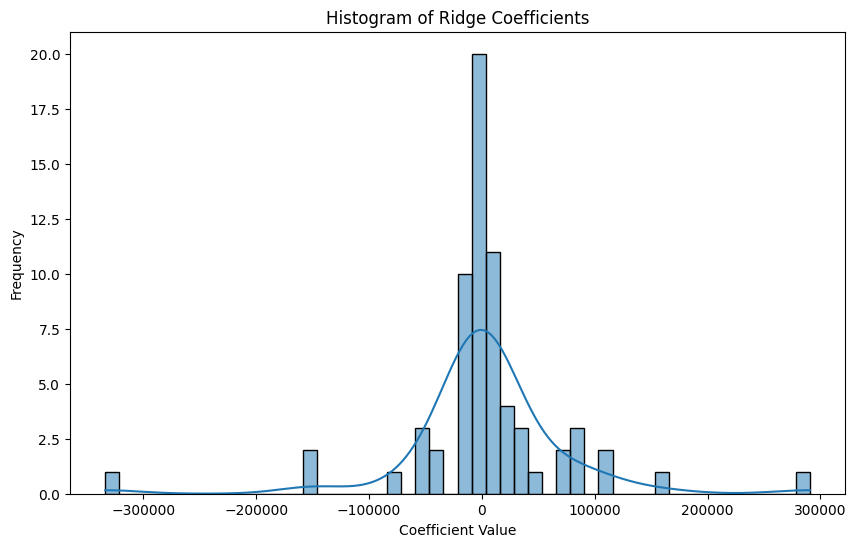

In [70]:
# histogram of coefficients
# ( courtesy to copilot autocomplete (｡•́︿•̀｡) )
plt.figure(figsize=(10, 6))
coefficients = ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled.coef_
sns.histplot(coefficients, bins=50, kde=True)
plt.title('Histogram of Ridge Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.show()

In [71]:
# Create a copy to apply L0 regularization
import copy
ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs = copy.deepcopy(ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled)

# Zeroing small coefficients
# courtesy to copilot autocomplete (＾▽＾)/
threshold = np.sort(np.abs(ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs.coef_))[-25] # keep top 25 coefficients
print(f"Ridge L0 threshold: {threshold:.4f}")
ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs.coef_[np.abs(ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs.coef_) < threshold] = 0
evaluate_model(ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs, X_train_final_final_scaled, y_train_final_final, "Ridge L0 Train")
evaluate_model(ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs, X_test_final_final_scaled, y_test_final_final, "Ridge L0 Test")


Ridge L0 threshold: 19736.8187
Ridge L0 Train:		 R^2: 0.8076,		 MSE: 234857 ^ 2
Ridge L0 Test:		 R^2: 0.7714,		 MSE: 362490 ^ 2


In [72]:
print("Top 25 Ridge Coefficients:")
coeffs = ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs.coef_
feature_names = X_train_final_final.columns
coeff_feature_pairs = sorted(zip(feature_names, coeffs), key=lambda x: abs(x[1]), reverse=True)[:25]
for feature, coeff in coeff_feature_pairs:
    print(f"{feature}: {coeff:.4f}")

Top 25 Ridge Coefficients:
max_power_num_mul_age: -333790.8177
torque_nm_mul_max_power_num: 290644.6748
mileage_num_mul_max_power_num: 157052.7970
torque_nm_mul_age: -148396.8516
km_driven_mul_max_power_num: -146763.4992
engine_num_mul_max_power_num: 112209.6028
km_driven_mul_age: 109755.0613
max_power_num_div_age: 81275.3631
max_power_num: 81208.0211
torque_rpm_max_mul_age: 81112.1795
owner_Test Drive Car: 76756.0118
km_driven_mul_engine_num: 74918.4178
mileage_num_mul_engine_num: -72849.6105
engine_num_mul_age: -55325.3728
transmission_Manual: -54585.2958
torque_rpm_max_mul_mileage_num: -48869.9623
torque_rpm_max_mul_engine_num: 42666.6352
km_driven_mul_mileage_num: -41507.5862
km_driven_mul_torque_nm: -41496.0854
torque_nm_mul_engine_num: 39715.0293
age: 39327.1908
torque_nm_mul_mileage_num: 35308.6922
mileage_num_mul_age: 20394.2369
engine_num_div_max_power_num: 19777.6254
engine_num_div_age: 19736.8187


# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [73]:
def business_metrics(y_true, y_pred, model_name=None):
    # number of y_pred that is less than 10% off from y_true
    # courtesy to copilot autocomplete (｡•̀ᴗ-)✧
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    within_10_percent = np.abs(y_true - y_pred) <= 0.1 * y_true
    count_within_10_percent = np.sum(within_10_percent)
    total_count = len(y_true)
    percentage_within_10_percent = (count_within_10_percent / total_count) * 100
    print(f"Within 10%{' for ' + model_name if model_name else ''}: {count_within_10_percent}/{total_count} ({percentage_within_10_percent:.2f}%)")
    return percentage_within_10_percent

# Evaluate ALL the previous models with their corresponding X and y data
# courtesy to... Opus 4.5, actually. Ugh.
print("=" * 80)
print("TRAIN SET EVALUATION - business_metrics (within 10%)")
print("=" * 80)

# Models trained on numeric features only (unscaled)
business_metrics(y_train, linreg_numeric_only_unscaled.predict(X_train), 
                 model_name="linreg_numeric_only_unscaled")

# Models trained on numeric features only (scaled)
business_metrics(y_train, linreg_numeric_only_scaled.predict(X_train_scaled), 
                 model_name="linreg_numeric_only_scaled")
business_metrics(y_train, lasso_numeric_only_scaled_alpha_0_1.predict(X_train_scaled), 
                 model_name="lasso_numeric_only_scaled_alpha_0_1")
business_metrics(y_train, lasso_gridsearch_10fold_numeric_scaled_best_alpha.predict(X_train_scaled), 
                 model_name="lasso_gridsearch_10fold_numeric_scaled_best_alpha")
business_metrics(y_train, elasticnet_gridsearch_10fold_numeric_scaled_best_params.predict(X_train_scaled), 
                 model_name="elasticnet_gridsearch_10fold_numeric_scaled_best_params")
business_metrics(y_train, linreg_numeric_scaled_L0_top_5_coeffs.predict(X_train_scaled), 
                 model_name="linreg_numeric_scaled_L0_top_5_coeffs")

# Models trained on features with categories and name (scaled)
business_metrics(y_train_final, ridge_gridsearch_10fold_with_categories_and_name_scaled.predict(X_train_final_scaled), 
                 model_name="ridge_gridsearch_10fold_with_categories_and_name_scaled")

# Models trained on features with categories but no name (scaled)
business_metrics(y_train_final, ridge_gridsearch_10fold_with_categories_no_name_scaled.predict(X_train_no_name_final_scaled), 
                 model_name="ridge_gridsearch_10fold_with_categories_no_name_scaled")

# Models trained on features with categories, no name, and FE interactions (scaled)
business_metrics(y_train_final_final, ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled.predict(X_train_final_final_scaled), 
                 model_name="ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled")
business_metrics(y_train_final_final, ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs.predict(X_train_final_final_scaled), 
                 model_name="ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs")

print("\n" + "=" * 80)
print("TEST SET EVALUATION - business_metrics (within 10%)")
print("=" * 80)

# Models trained on numeric features only (unscaled)
business_metrics(y_test, linreg_numeric_only_unscaled.predict(X_test), 
                 model_name="linreg_numeric_only_unscaled")

# Models trained on numeric features only (scaled)
business_metrics(y_test, linreg_numeric_only_scaled.predict(X_test_scaled), 
                 model_name="linreg_numeric_only_scaled")
business_metrics(y_test, lasso_numeric_only_scaled_alpha_0_1.predict(X_test_scaled), 
                 model_name="lasso_numeric_only_scaled_alpha_0_1")
business_metrics(y_test, lasso_gridsearch_10fold_numeric_scaled_best_alpha.predict(X_test_scaled), 
                 model_name="lasso_gridsearch_10fold_numeric_scaled_best_alpha")
business_metrics(y_test, elasticnet_gridsearch_10fold_numeric_scaled_best_params.predict(X_test_scaled), 
                 model_name="elasticnet_gridsearch_10fold_numeric_scaled_best_params")
business_metrics(y_test, linreg_numeric_scaled_L0_top_5_coeffs.predict(X_test_scaled), 
                 model_name="linreg_numeric_scaled_L0_top_5_coeffs")

# Models trained on features with categories and name (scaled)
business_metrics(y_test_final, ridge_gridsearch_10fold_with_categories_and_name_scaled.predict(X_test_final_scaled), 
                 model_name="ridge_gridsearch_10fold_with_categories_and_name_scaled")

# Models trained on features with categories but no name (scaled)
business_metrics(y_test_final, ridge_gridsearch_10fold_with_categories_no_name_scaled.predict(X_test_no_name_final_scaled), 
                 model_name="ridge_gridsearch_10fold_with_categories_no_name_scaled")

# Models trained on features with categories, no name, and FE interactions (scaled)
business_metrics(y_test_final_final, ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled.predict(X_test_final_final_scaled), 
                 model_name="ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled")
business_metrics(y_test_final_final, ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs.predict(X_test_final_final_scaled), 
                 model_name="ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs")

""

TRAIN SET EVALUATION - business_metrics (within 10%)
Within 10% for linreg_numeric_only_unscaled: 1269/5840 (21.73%)
Within 10% for linreg_numeric_only_scaled: 1269/5840 (21.73%)
Within 10% for lasso_numeric_only_scaled_alpha_0_1: 1269/5840 (21.73%)
Within 10% for lasso_gridsearch_10fold_numeric_scaled_best_alpha: 1325/5840 (22.69%)
Within 10% for elasticnet_gridsearch_10fold_numeric_scaled_best_params: 1310/5840 (22.43%)
Within 10% for linreg_numeric_scaled_L0_top_5_coeffs: 1289/5840 (22.07%)
Within 10% for ridge_gridsearch_10fold_with_categories_and_name_scaled: 3513/5840 (60.15%)
Within 10% for ridge_gridsearch_10fold_with_categories_no_name_scaled: 1277/5840 (21.87%)
Within 10% for ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled: 1575/5840 (26.97%)
Within 10% for ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs: 1429/5840 (24.47%)

TEST SET EVALUATION - business_metrics (within 10%)
Within 10% for linreg_numeric_only_unsc

''

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [74]:
def your_business_metrics(y_true, y_pred, model_name=None):
    # weighted reward: 1 if exact match, then -0.15 for each percent off leftward and -0.05 rightward, minimum 0
    rewards = []
    for true, pred in zip(y_true, y_pred):
        if true >= pred:
            rewards.append(max(0, 1 - 5 * (true - pred) / true))
        else:
            rewards.append(max(0, 1 - 15 * (pred - true) / true))
    print(f"Average reward{' for ' + model_name if model_name else ''}: {np.mean(rewards):.4f}")
    return np.mean(rewards)

# Evaluate ALL the previous models with their corresponding X and y data
# courtesy to... Opus 4.5, actually. Ugh.
print("=" * 80)
print("TRAIN SET EVALUATION")
print("=" * 80)

# Models trained on numeric features only (unscaled)
your_business_metrics(y_train, linreg_numeric_only_unscaled.predict(X_train), 
                      model_name="linreg_numeric_only_unscaled")

# Models trained on numeric features only (scaled)
your_business_metrics(y_train, linreg_numeric_only_scaled.predict(X_train_scaled), 
                      model_name="linreg_numeric_only_scaled")
your_business_metrics(y_train, lasso_numeric_only_scaled_alpha_0_1.predict(X_train_scaled), 
                      model_name="lasso_numeric_only_scaled_alpha_0_1")
your_business_metrics(y_train, lasso_gridsearch_10fold_numeric_scaled_best_alpha.predict(X_train_scaled), 
                      model_name="lasso_gridsearch_10fold_numeric_scaled_best_alpha")
your_business_metrics(y_train, elasticnet_gridsearch_10fold_numeric_scaled_best_params.predict(X_train_scaled), 
                      model_name="elasticnet_gridsearch_10fold_numeric_scaled_best_params")
your_business_metrics(y_train, linreg_numeric_scaled_L0_top_5_coeffs.predict(X_train_scaled), 
                      model_name="linreg_numeric_scaled_L0_top_5_coeffs")

# Models trained on features with categories and name (scaled)
your_business_metrics(y_train_final, ridge_gridsearch_10fold_with_categories_and_name_scaled.predict(X_train_final_scaled), 
                      model_name="ridge_gridsearch_10fold_with_categories_and_name_scaled")

# Models trained on features with categories but no name (scaled)
your_business_metrics(y_train_final, ridge_gridsearch_10fold_with_categories_no_name_scaled.predict(X_train_no_name_final_scaled), 
                      model_name="ridge_gridsearch_10fold_with_categories_no_name_scaled")

# Models trained on features with categories, no name, and FE interactions (scaled)
your_business_metrics(y_train_final_final, ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled.predict(X_train_final_final_scaled), 
                      model_name="ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled")
your_business_metrics(y_train_final_final, ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs.predict(X_train_final_final_scaled), 
                      model_name="ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs")

print("\n" + "=" * 80)
print("TEST SET EVALUATION")
print("=" * 80)

# Models trained on numeric features only (unscaled)
your_business_metrics(y_test, linreg_numeric_only_unscaled.predict(X_test), 
                      model_name="linreg_numeric_only_unscaled")

# Models trained on numeric features only (scaled)
your_business_metrics(y_test, linreg_numeric_only_scaled.predict(X_test_scaled), 
                      model_name="linreg_numeric_only_scaled")
your_business_metrics(y_test, lasso_numeric_only_scaled_alpha_0_1.predict(X_test_scaled), 
                      model_name="lasso_numeric_only_scaled_alpha_0_1")
your_business_metrics(y_test, lasso_gridsearch_10fold_numeric_scaled_best_alpha.predict(X_test_scaled), 
                      model_name="lasso_gridsearch_10fold_numeric_scaled_best_alpha")
your_business_metrics(y_test, elasticnet_gridsearch_10fold_numeric_scaled_best_params.predict(X_test_scaled), 
                      model_name="elasticnet_gridsearch_10fold_numeric_scaled_best_params")
your_business_metrics(y_test, linreg_numeric_scaled_L0_top_5_coeffs.predict(X_test_scaled), 
                      model_name="linreg_numeric_scaled_L0_top_5_coeffs")

# Models trained on features with categories and name (scaled)
your_business_metrics(y_test_final, ridge_gridsearch_10fold_with_categories_and_name_scaled.predict(X_test_final_scaled), 
                      model_name="ridge_gridsearch_10fold_with_categories_and_name_scaled")

# Models trained on features with categories but no name (scaled)
your_business_metrics(y_test_final, ridge_gridsearch_10fold_with_categories_no_name_scaled.predict(X_test_no_name_final_scaled), 
                      model_name="ridge_gridsearch_10fold_with_categories_no_name_scaled")

# Models trained on features with categories, no name, and FE interactions (scaled)
your_business_metrics(y_test_final_final, ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled.predict(X_test_final_final_scaled), 
                      model_name="ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled")
your_business_metrics(y_test_final_final, ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs.predict(X_test_final_final_scaled), 
                      model_name="ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs")

""

TRAIN SET EVALUATION
Average reward for linreg_numeric_only_unscaled: 0.1456
Average reward for linreg_numeric_only_scaled: 0.1456
Average reward for lasso_numeric_only_scaled_alpha_0_1: 0.1456
Average reward for lasso_gridsearch_10fold_numeric_scaled_best_alpha: 0.1512
Average reward for elasticnet_gridsearch_10fold_numeric_scaled_best_params: 0.1513
Average reward for linreg_numeric_scaled_L0_top_5_coeffs: 0.1430
Average reward for ridge_gridsearch_10fold_with_categories_and_name_scaled: 0.4318
Average reward for ridge_gridsearch_10fold_with_categories_no_name_scaled: 0.1525
Average reward for ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled: 0.1876
Average reward for ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs: 0.1606

TEST SET EVALUATION
Average reward for linreg_numeric_only_unscaled: 0.1657
Average reward for linreg_numeric_only_scaled: 0.1657
Average reward for lasso_numeric_only_scaled_alpha_0_1: 0.1657
Average re

''

# **<font color="green">Часть 5 | Создание интерактивного приложения на Streamlit (3 балла)</font>**

Вам необходимо создать интерактивное приложение на Streamlit, которое будет:

- Показывать основные информативные графики/гистограммы в рамках EDA (1 балл)
- На вход запрашивать csv-файл с признаками объектов или запрашивать признаки объекта в окошках для ввода, и применять на поступивших объектах модель (1 балл)
- Визуализировать веса обученной модели (1 балл)

# **Часть 6 | Оформление репозитория и оценка сервиса (3 балла)**

**Результаты вашей работы** необходимо разместить в своём GitHub-репозитории. В этот же репозиторий позже будет добавлена вторая часть.

Под результатами первой части понимаем следующее:

---

### Обязательные файлы:

1. **`.ipynb`-ноутбук** со всеми экспериментами:

   * полный EDA,
   * все шаги препроцессинга,
   * обучение и сравнение моделей,
   * сохранённые output’ы.

2. **`.pickle`-файл**, содержащий:

   * обученную модель (или пайплайн `scaler + model`);
   * параметры скейлинга;
   * любые числовые объекты, необходимые для инференса внутри Streamlit-приложения.

3. **`.md`-файл с выводами** о проделанной работе:

   * что было сделано (краткое описание каждого этапа);
   * какие результаты были получены (метрики + интерпретация);
   * что дало наибольший прирост качества;
   * что сделать не удалось и почему (это нормально и даже полезно);
   * **оценка разработанного сервиса**:

     * насколько приложение удобно в использовании;
     * что получилось визуализировать хорошо, а что — менее удачно;
     * какие ограничения или проблемы вы заметили;
     * какие улучшения планируете в следующей итерации.

По результатам второй части, ждем:

4. **Streamlit-приложение** (например, `app.py`), которое можно запустить командой:

   ```bash
   streamlit run app.py
   ```

В приложении должно быть:

* отображение ключевых графиков EDA;
* ввод данных (CSV или ручной ввод);
* применение модели;
* визуализация весов/коэффициентов.

**И ссылку на приложение в StreamlitHub.**


### **За что могут быть сняты баллы:**

* отсутствие `.pickle` с моделью / пайплайном;
* слабая или неполная аналитика в `.md`-файле;
* беспорядок в ноутбуке или неясная логика вычислений;
* отсутствие возможности запустить Streamlit-приложение.


In [81]:
import pickle

# This would NOT be compatible with the streamlit app.
# with open('ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs.pickle', 'wb') as f:
#     pickle.dump(ridge_10fold_with_categories_no_name_with_fe_interactions_scaled_L0_top_25_coeffs, f)

# Make sure to use the same format!

model_to_export = ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled
scaler_to_export = scaler_fe

def export_model(model, scaler, columns, X_train, y_train, X_test, y_test, path='model.pickle'):
    # Calculate metrics on test set
    y_pred_test = model.predict(X_test)
    r2 = r2_score(y_test, y_pred_test)
    rmse = math.sqrt(MSE(y_test, y_pred_test))
    metrics = {
        'R2': r2,
        'RMSE': rmse
    }
    # Extract coefficients
    # Using the columns from the final training set
    coefs = pd.Series(model.coef_, index=columns)
    export_data = {
        'model': model,
        'scaler': scaler,
        'metrics': metrics,
        'coefficients': coefs
    }
    with open(path, 'wb') as f:
        pickle.dump(export_data, f)
    print("Model exported successfully to model.pickle")
    print("Metrics:", metrics)

export_model(
    model_to_export, 
    scaler_to_export, 
    X_train_final_final.columns,
    X_train_final_final_scaled,
    y_train_final_final, 
    X_test_final_final_scaled, 
    y_test_final_final, 
    'ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled.pickle'
)


Model exported successfully to model.pickle
Metrics: {'R2': 0.7873591740699583, 'RMSE': 349616.96017088724}


In [82]:
def import_model(filepath):
    with open(filepath, 'rb') as f:
        export_data = pickle.load(f)
    model = export_data['model']
    scaler = export_data['scaler']
    metrics = export_data['metrics']
    coefs = export_data['coefficients']
    return model, scaler, metrics, coefs

model, scaler, metrics, coefs = import_model('ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled.pickle')

print("Model imported successfully from ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled.pickle")

print("Metrics:", metrics)
print("Coefficients:", coefs)

# Use the model to make predictions
X_test_final_final_scaled = scaler.transform(X_test_final_final)
y_pred_test = model.predict(X_test_final_final_scaled)

# Calculate metrics on test set
r2 = r2_score(y_test_final_final, y_pred_test)
rmse = math.sqrt(MSE(y_test_final_final, y_pred_test))

print("R2:", r2)
print("RMSE:", rmse)


Model imported successfully from ridge_gridsearch_10fold_with_categories_no_name_with_fe_interactions_scaled.pickle
Metrics: {'R2': 0.7873591740699583, 'RMSE': 349616.96017088724}
Coefficients: km_driven                         3618.342029
torque_nm                        -3314.997428
torque_rpm_max                  -10244.780022
mileage_num                      -7966.513971
engine_num                       19733.497618
                                    ...      
engine_num_div_max_power_num     19777.625403
engine_num_mul_age              -55325.372769
engine_num_div_age               19736.818724
max_power_num_mul_age          -333790.817707
max_power_num_div_age            81275.363145
Length: 67, dtype: float64
R2: 0.7873591740699583
RMSE: 349616.96017088724
